# Dual CRISPR Screen Analysis Pipeline
# Module 1
Amanda Birmingham, CCBB, UCSD (abirmingham@ucsd.edu)

Roman Sasik, CCBB, UCSD (rsasik@ucsd.edu)

## System Requirements
You will need to have python 3, perl, Roman's perl script, and the CV4_2spacers.txt file on your system, as well as the following third-party python libraries: matplotlib, numpy, pandas.


## Instructions

Fill in the variables below and then run the notebook to get:
* Individual raw count files for each pair of fastq files (forward and reverse reads for each sample)
* One combined count file that includes the counts for each sample as a separate column
* One combined boxplot showing the log2 of the raw counts for each sample in the run as a separate series
* Individual boxplots of the log2 of the raw counts for each sample
* Individual histograms of the log2 of the raw counts for each sample

In [2]:
g_dataset_name = "20160506_u2os"
g_fastq_dir = "/Users/Birmingham/Repositories/custom_analysis_pipelines/20160210_mali_crispr/data/raw/20160506_data"
g_working_dir = "/Users/Birmingham/Repositories/custom_analysis_pipelines/20160210_mali_crispr/data/processed/20160506_data"
g_alg_name = "1mm"
g_perl_script_fp = "/Users/Birmingham/Repositories/custom_analysis_pipelines/20160210_mali_crispr/src/perl/fastq2gg_counts.pl"

In [29]:
%matplotlib inline

In [3]:
import glob
import os


def get_file_name_pieces(file_path):
    file_dir, filename = os.path.split(file_path)
    file_base, file_ext = os.path.splitext(filename)
    return file_dir, file_base, file_ext


def get_wild_path(directory, wildcard_filename,
                                prefix_asterisk=True):
    wildcard_filename = (("*" + wildcard_filename) if prefix_asterisk
                         else wildcard_filename)
    return os.path.join(directory, wildcard_filename)    

    
def get_filepaths_from_wildcard(directory, wildcard_filename,
                                prefix_asterisk=True):
    wildpath = get_wild_path(directory, wildcard_filename,
                                prefix_asterisk)
    return [x for x in glob.glob(wildpath)]

In [4]:
# gunzip the gzipped files; do this from shell because doing through 
# python gzip module is slow
def unzip_fastqs(directory):
    gz_wildpath = get_wild_path(directory, '*.fastq.gz')
    !gunzip {gz_wildpath}

In [5]:
def group_read_pairs(fastq_filepaths):
    fastq_filepaths.sort() # ensure R1 always before R2 in list
    fastq_pairs_per_sample = {}

    for curr_fastq_path in fastq_filepaths:
        sample_path = str.replace(curr_fastq_path, "_R1_", "_", 1)
        sample_path = str.replace(sample_path, "_R2_", "_", 1)
        path, sample_base, extension = get_file_name_pieces(sample_path)
        
        if not sample_base in fastq_pairs_per_sample:
            fastq_pairs_per_sample[sample_base] = [curr_fastq_path]
        else:
            fastq_pairs_per_sample[sample_base].append(curr_fastq_path)  
    
    return fastq_pairs_per_sample

In [6]:
import subprocess

g_divider = "----------------------------"
g_encoding = "utf-8"


def join_lines(lines_list):
    return "\n".join(lines_list)


def strip_and_append_non_empty(an_input, output_list):
    if isinstance(an_input, bytes):
        an_input = an_input.decode(g_encoding)
    stripped_input = an_input.strip()
    if stripped_input != "":
        output_list.append(stripped_input)    

        
def basic_summarizer(err, output, results=None, curr_key=None):
    summary_pieces = []
    strip_and_append_non_empty(err, summary_pieces)
    strip_and_append_non_empty(output, summary_pieces)
    return join_lines(summary_pieces)


def summarize_subprocess(err, output, results=None, 
                         curr_key=None, 
                         summarizer_function=basic_summarizer): 
    summary_pieces = []
    specific_summary = summarizer_function(err, output, results, 
                                           curr_key)
    if curr_key is not None:
        summary_pieces.append(curr_key + ":")
    summary_pieces.append(specific_summary)
    summary_pieces.append(g_divider)
    return join_lines(summary_pieces)


def run_subprocess(source_name, call_args, results_dict=None, 
                   summarizer_function=basic_summarizer):
    process = subprocess.Popen(call_args, shell=False, stdout=subprocess.PIPE, 
                               stderr=subprocess.PIPE)
    output, err = process.communicate()  
    summary = summarize_subprocess(err, output, results_dict, source_name, 
                                  summarizer_function)
    return summary, results_dict

In [45]:
import os


def count_constructs_in_paired_fastqs(process_name, perl_script_fp, fw_fastq_fp, rv_fastq_fp, output_fp):    
    # perl fastq2gg_counts.pl CV4-Plasmid_S1_L001_R1_001.fastq CV4-Plasmid_S1_L001_R2_001.fastq CV4-Plasmid_counts.txt
    call_args = ["perl", perl_script_fp, fw_fastq_fp, rv_fastq_fp, output_fp]    
    summary, results = run_subprocess(process_name, call_args)
    return summary


def generate_counts_for_each_fastq_pair(fastq_dir, perl_script_fp, output_dir, dataset_name, alg_name):
    unzip_fastqs(fastq_dir)
    
    # get all fastq files in fastq dir
    fastq_filepaths = get_filepaths_from_wildcard(fastq_dir, ".fastq")
    
    # pair reads
    paired_fastqs_by_base = group_read_pairs(fastq_filepaths)
    
    # run the perl script on each fastq file
    for curr_base, fp_list in paired_fastqs_by_base.items():
        output_filename = "{0}_{1}_{2}_counts.txt".format(dataset_name, curr_base, alg_name)
        output_fp = os.path.join(output_dir, output_filename)
        summary = count_constructs_in_paired_fastqs(curr_base, perl_script_fp, fp_list[0], fp_list[1], output_fp)
        print(summary)

In [46]:
generate_counts_for_each_fastq_pair(g_fastq_dir, g_perl_script_fp, g_working_dir, g_dataset_name, g_alg_name)

U2OS-CAS9TREX2A-t28_S5_L002_001:

----------------------------
U2OS-CAS9TREX2B-t28_S6_L001_001:

----------------------------
U2OS-CAS9TREX2B-t14_S2_L002_001:

----------------------------
U2OS-CAS9TREX2B-t28_S6_L002_001:

----------------------------
U2OS-Parent-t28_S3_L002_001:

----------------------------
U2OS-CAS9TREX2A-t14_S1_L002_001:

----------------------------
U2OS-Parent-t28_S3_L001_001:

----------------------------
U2OS-CAS9TREX2A-t28_S5_L001_001:

----------------------------
U2OS-CAS9B-t28_S4_L002_001:

----------------------------
U2OS-CAS9TREX2A-t14_S1_L001_001:

----------------------------
Undetermined_S0_L001_001:

----------------------------
U2OS-CAS9B-t28_S4_L001_001:

----------------------------
Undetermined_S0_L002_001:

----------------------------
U2OS-CAS9TREX2B-t14_S2_L001_001:

----------------------------


In [7]:
import os
import pandas

g_counts_file_suffix = "counts.txt"
g_counts_combined_file_suffix = "counts_combined.txt"


def build_detailed_fp(working_dir, name_pieces):
    filename = "_".join(name_pieces)
    output_fp = os.path.join(working_dir, filename)
    return output_fp


def get_count_fps_for_dataset(working_dir, dataset_name, alg_name, counts_suffix):
    output_fp = build_detailed_fp(working_dir, [dataset_name, alg_name, counts_suffix])
    counts_fps = get_filepaths_from_wildcard(working_dir, counts_suffix)
    counts_fps_for_dataset = [x for x in counts_fps if dataset_name in x]
    return counts_fps_for_dataset


def get_counts_df(counts_fp):
    curr_counts_df = pandas.read_table(counts_fp)
    orig_count_header = curr_counts_df.columns.values[-1]  # last column
    _, revised_count_header = os.path.split(orig_count_header)
    curr_counts_df.rename(columns={orig_count_header: revised_count_header}, inplace=True)    
    return revised_count_header, curr_counts_df


def combine_count_files(counts_fp_for_dataset):
    combined_df = None
    
    for curr_counts_fp in counts_fp_for_dataset:
        count_header, curr_counts_df = get_counts_df(curr_counts_fp)
        
        if combined_df is None:
            combined_df = curr_counts_df
        else:
            combined_df[count_header] = curr_counts_df[count_header]
    
    return combined_df


def write_combined_count_file(working_dir, dataset_name, alg_name, counts_suffix, combined_suffix):
    output_fp = build_detailed_fp(working_dir, [dataset_name, alg_name, combined_suffix])
    counts_fps_for_dataset = get_count_fps_for_dataset(working_dir, dataset_name, alg_name, counts_suffix)
    combined_df = combine_count_files(counts_fps_for_dataset)
    combined_df.to_csv(output_fp, index=False)

In [ ]:
write_combined_count_file(g_working_dir, g_dataset_name, g_alg_name, g_counts_file_suffix, 
                          g_counts_combined_file_suffix)

In [26]:
import matplotlib.pyplot as plt
from numpy import log2, inf, nan
import pandas

g_counts_boxplot_suffix = "boxplots.png"


def make_log2_series(input_series):
    log2_series = input_series.apply(log2)
    nan_log2_series = log2_series.replace([inf, -inf], nan)   
    return nan_log2_series.dropna()
    

def show_and_save_histogram(output_fp, title, count_data):
    plt.figure(figsize=(20,20))
    plt.hist(count_data)
    plt.title(title)
    plt.xlabel("log2(raw counts)")
    plt.ylabel("Frequency")
    plt.savefig(output_fp)    
    plt.show()


def show_and_save_boxplot(output_fp, title, samples_names, samples_data, rotation_val=0):
    fig = plt.figure(1, figsize=(20,20))
    ax = fig.add_subplot(111)
    bp = ax.boxplot(samples_data)
    ax.set_xticklabels(samples_names, rotation=rotation_val)   
    ax.set_xlabel("samples")
    ax.set_ylabel("log2(raw counts)")

    plt.title(title)
    fig.savefig(output_fp, bbox_inches='tight')            
    plt.show()    


def plot_raw_counts(working_dir, dataset_name, alg_name, counts_suffix, boxplot_suffix):
    counts_fps_for_dataset = get_count_fps_for_dataset(working_dir, dataset_name, alg_name, counts_suffix)
    
    for curr_counts_fp in counts_fps_for_dataset:
        count_header, curr_counts_df = get_counts_df(curr_counts_fp)
        log2_series = make_log2_series(curr_counts_df[count_header])       
        
        title = " ".join([dataset_name, alg_name, count_header])
        
        boxplot_fp = build_detailed_fp(working_dir, [dataset_name, alg_name, count_header, boxplot_suffix])        
        show_and_save_boxplot(boxplot_fp, title, [count_header], log2_series)
        
        hist_fp = build_detailed_fp(working_dir, [dataset_name, alg_name, count_header, "hist.png"])  
        show_and_save_histogram(hist_fp, title, log2_series)
        
        
def plot_combined_raw_counts(working_dir, dataset_name, alg_name, combined_suffix, boxplot_suffix):
    output_fp = build_detailed_fp(working_dir, [dataset_name, alg_name, boxplot_suffix])
    combined_counts_fp = build_detailed_fp(working_dir, [dataset_name, alg_name, combined_suffix])
    combined_counts_df = pandas.read_csv(combined_counts_fp)
    samples_names = combined_counts_df.columns.values[3:]
    samples_data = []
    for curr_name in samples_names:
        log2_series = make_log2_series(combined_counts_df[curr_name])
        samples_data.append(log2_series.tolist())
        
    title = " ".join([dataset_name, alg_name, "all samples"])        
    show_and_save_boxplot(output_fp, title, samples_names, samples_data, 90)

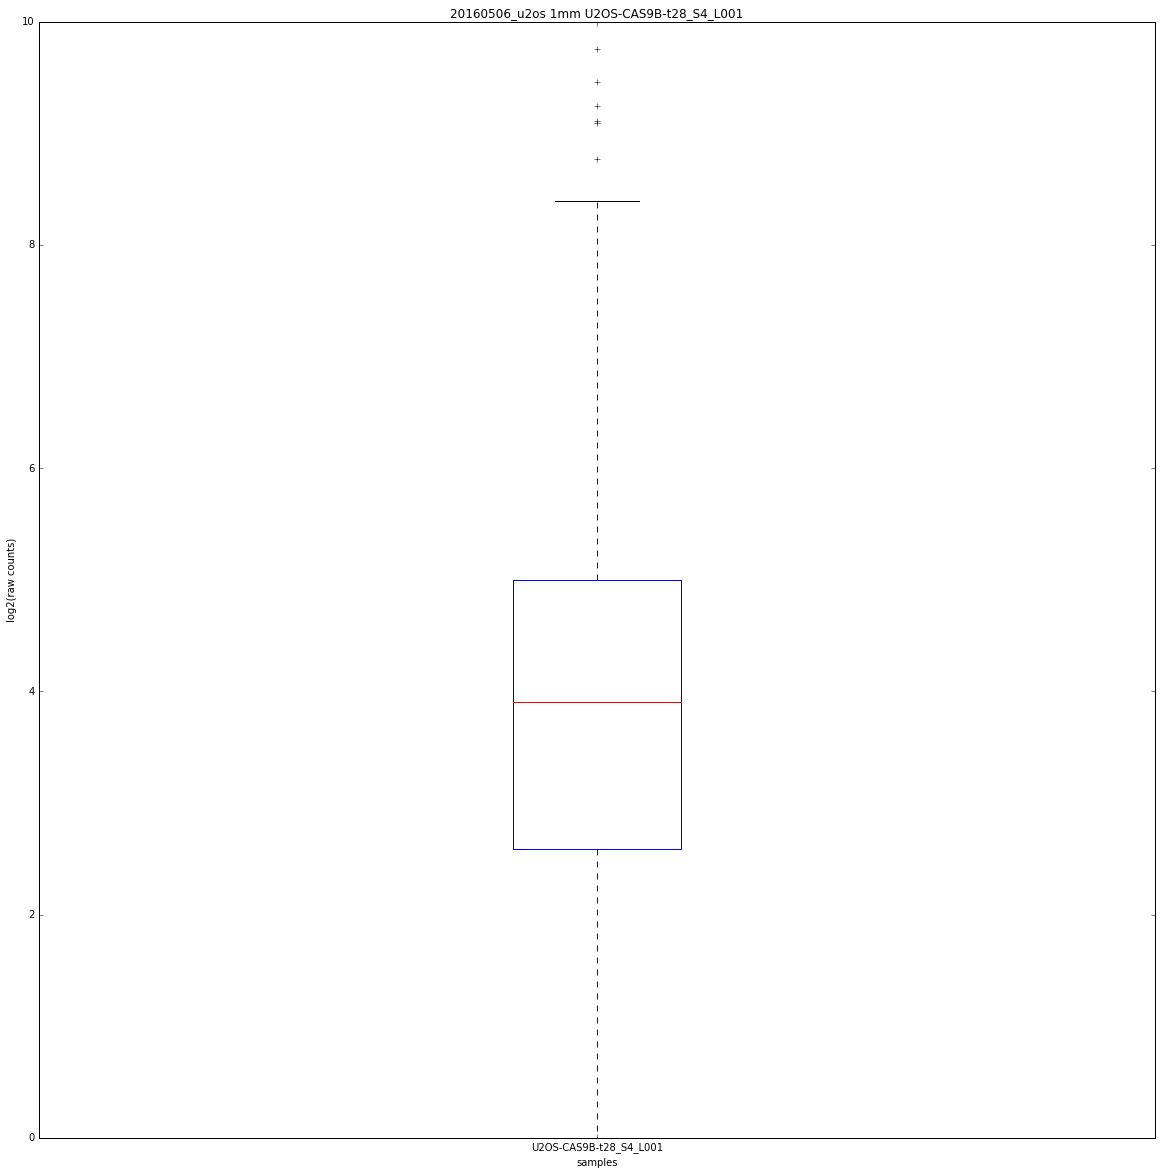

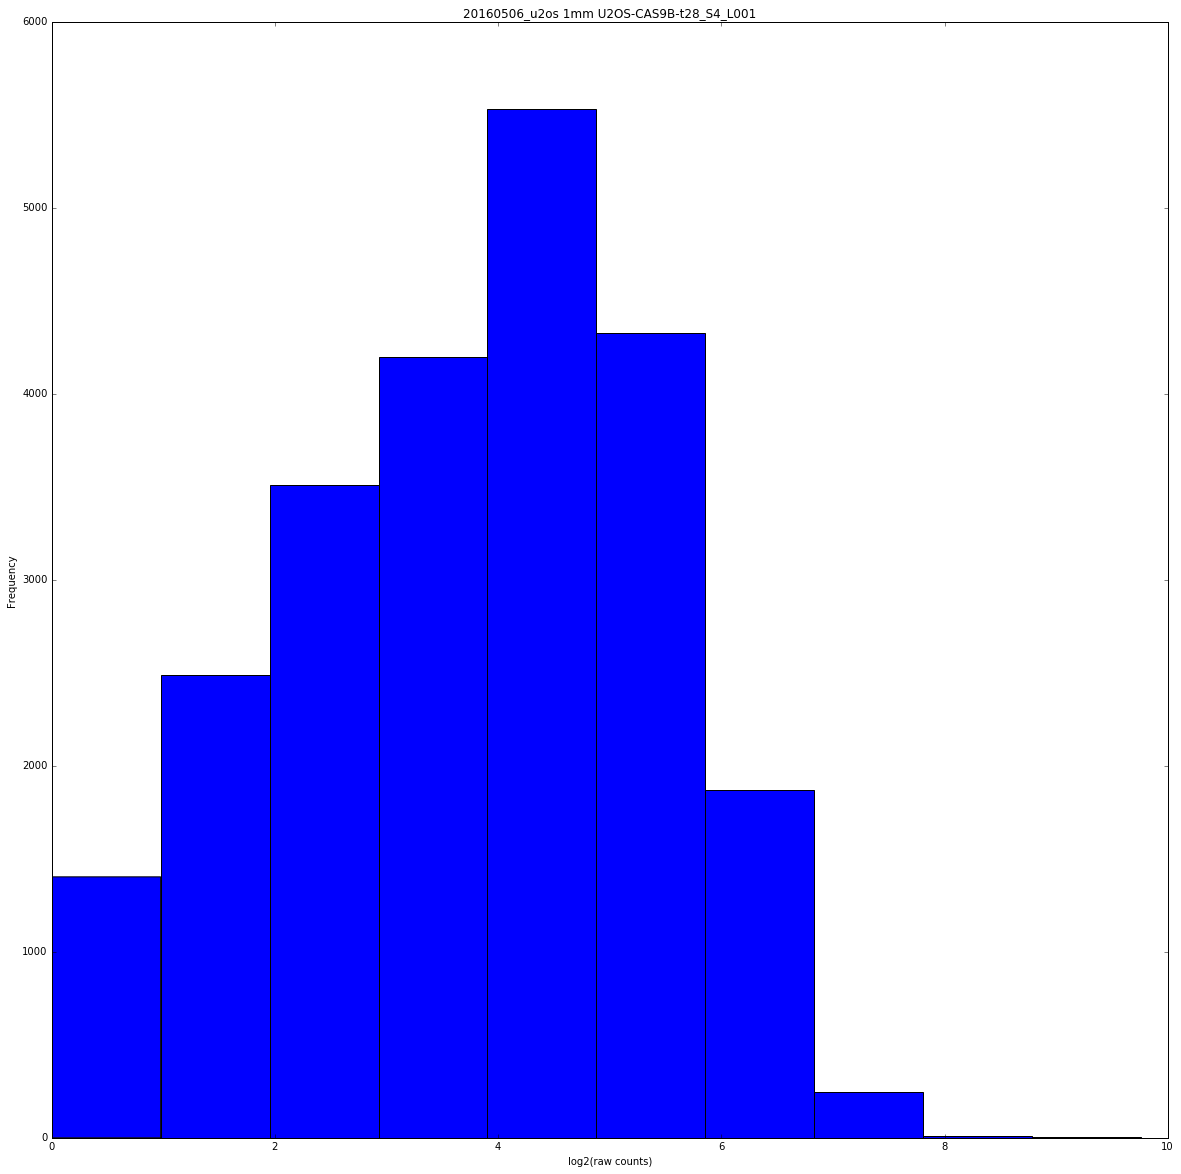

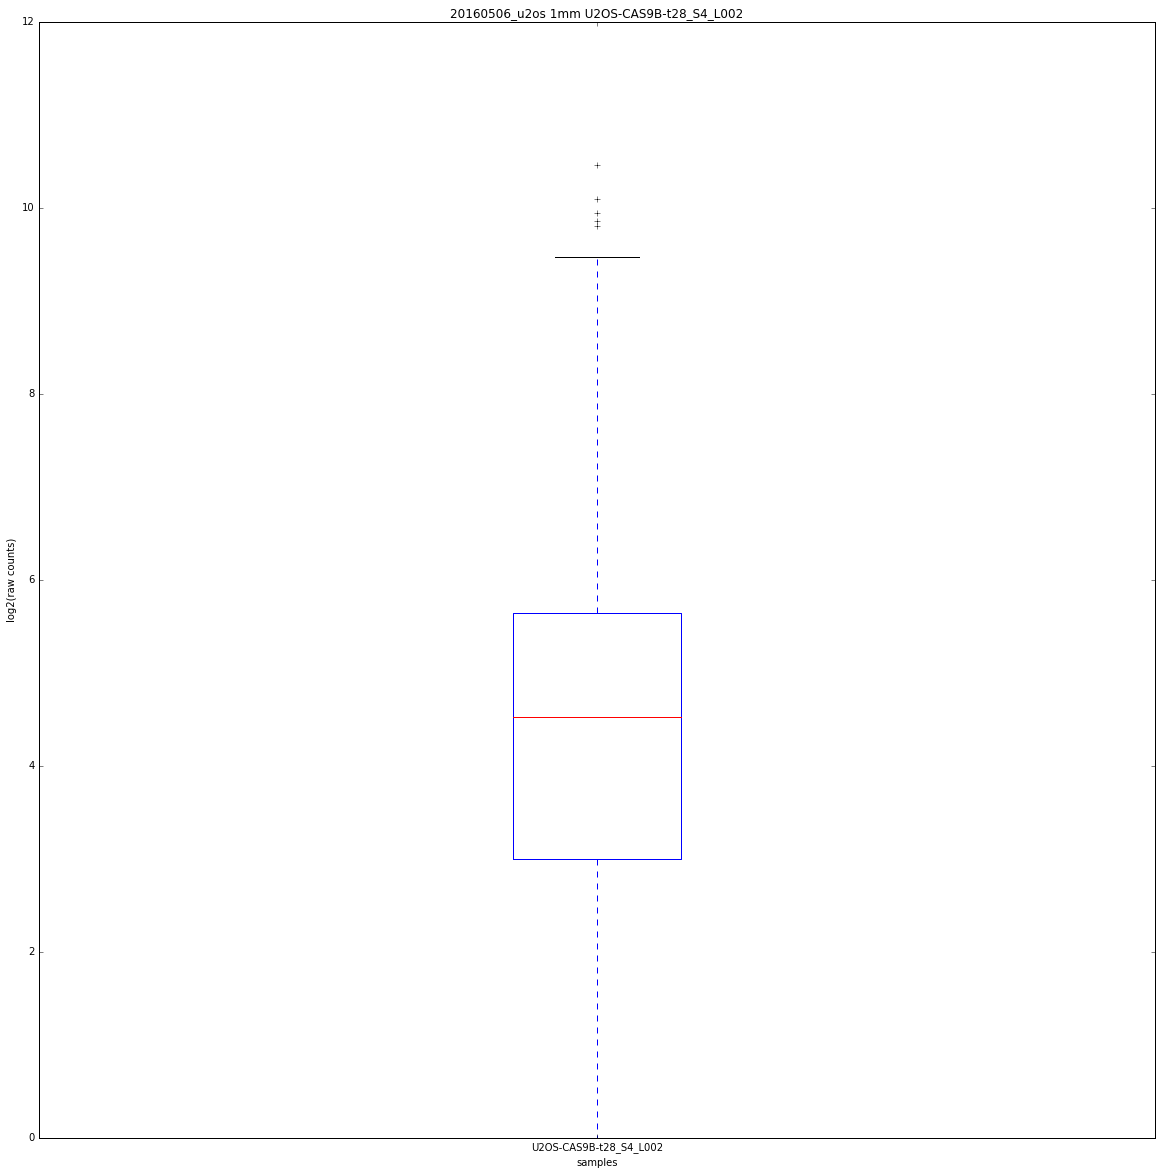

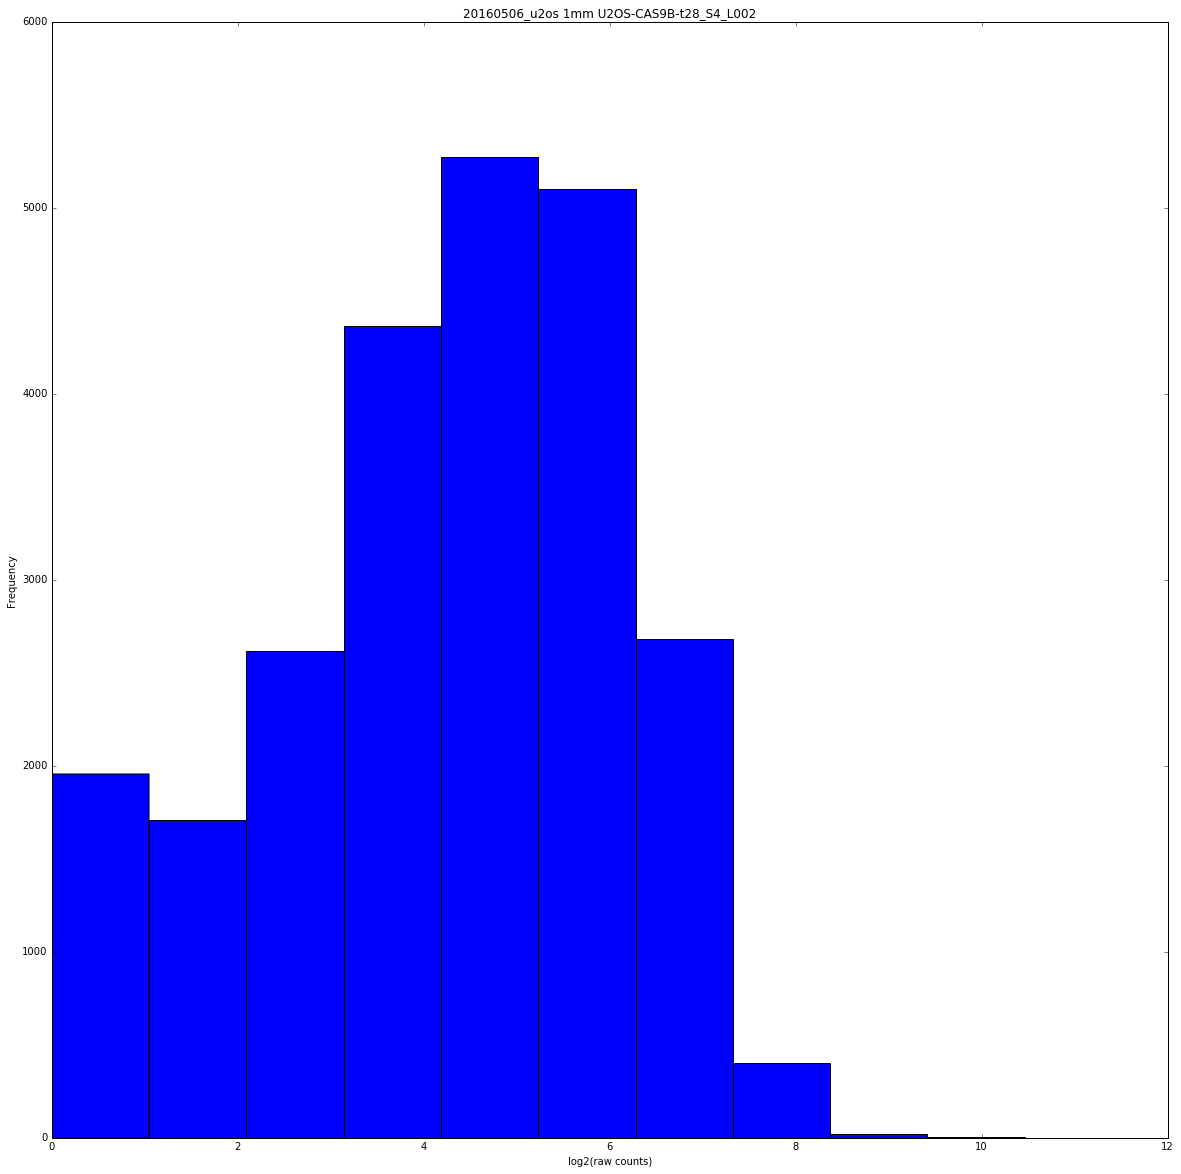

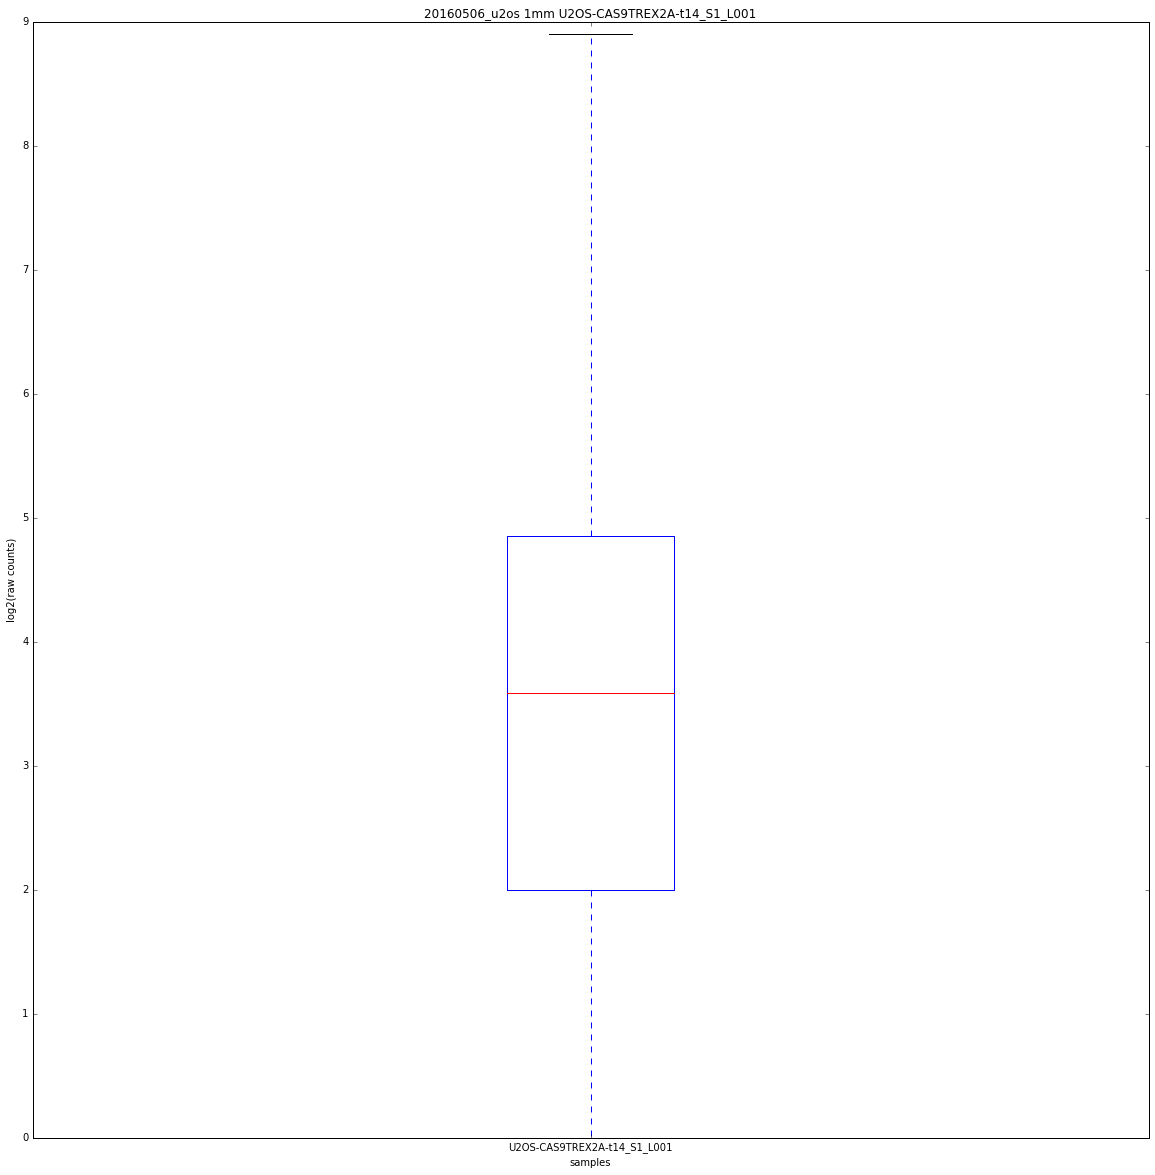

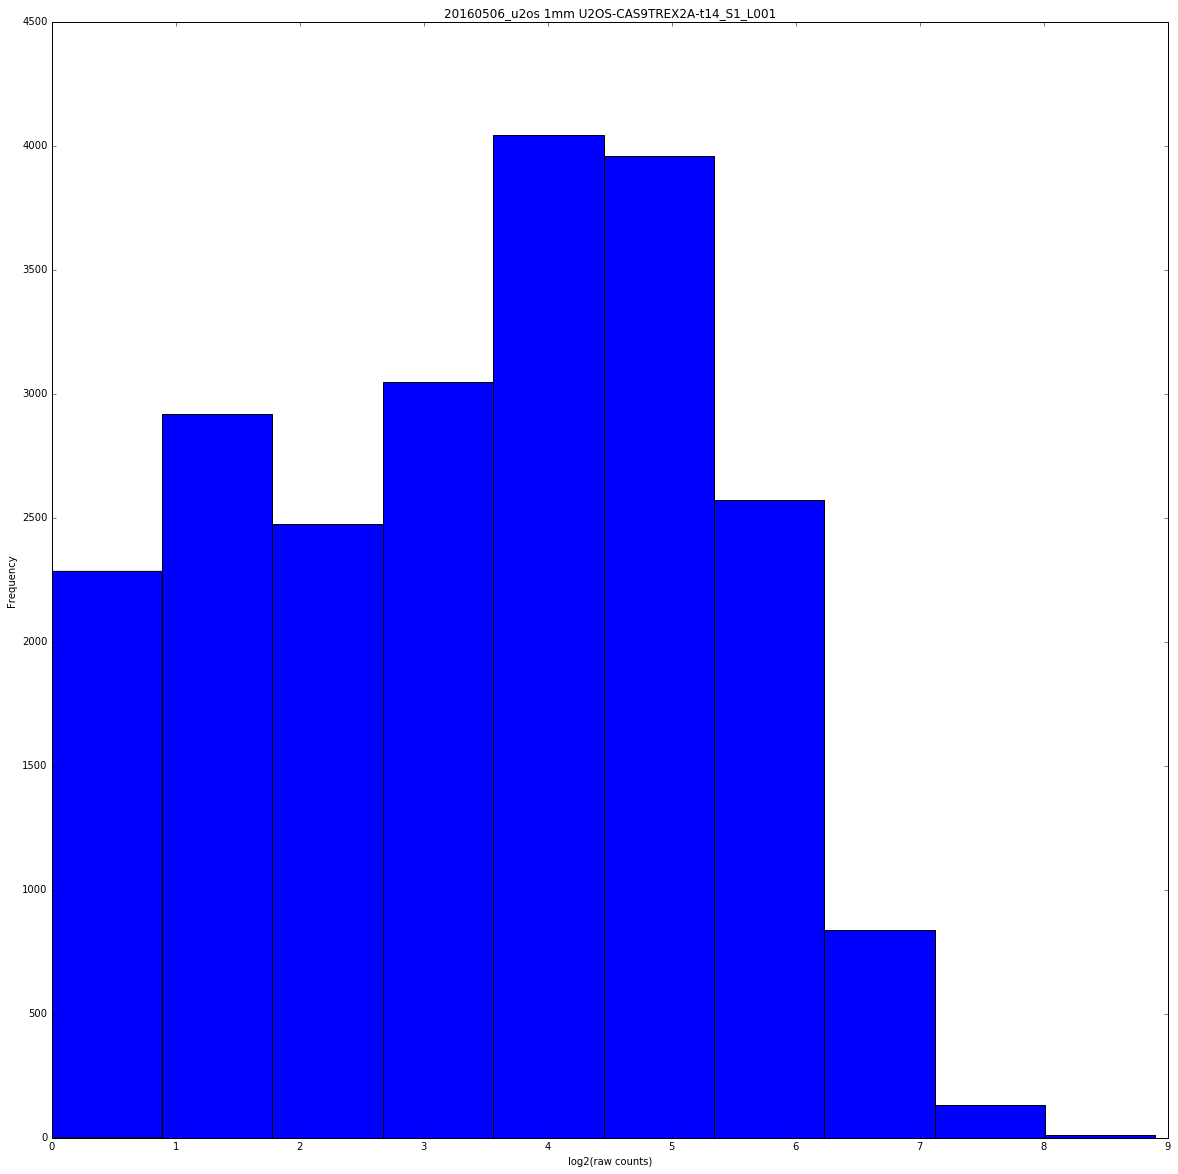

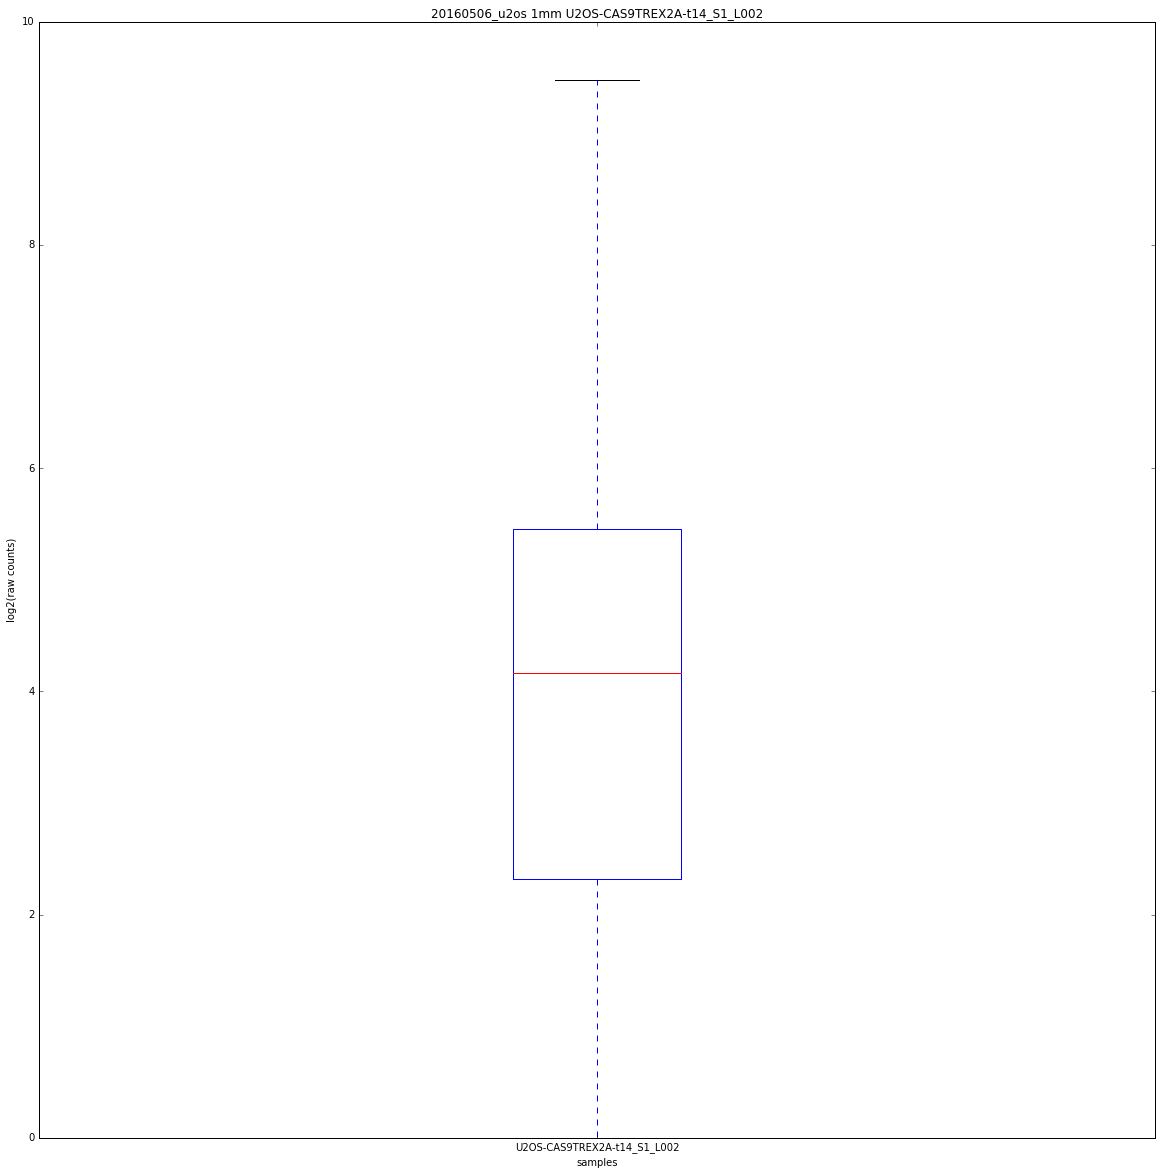

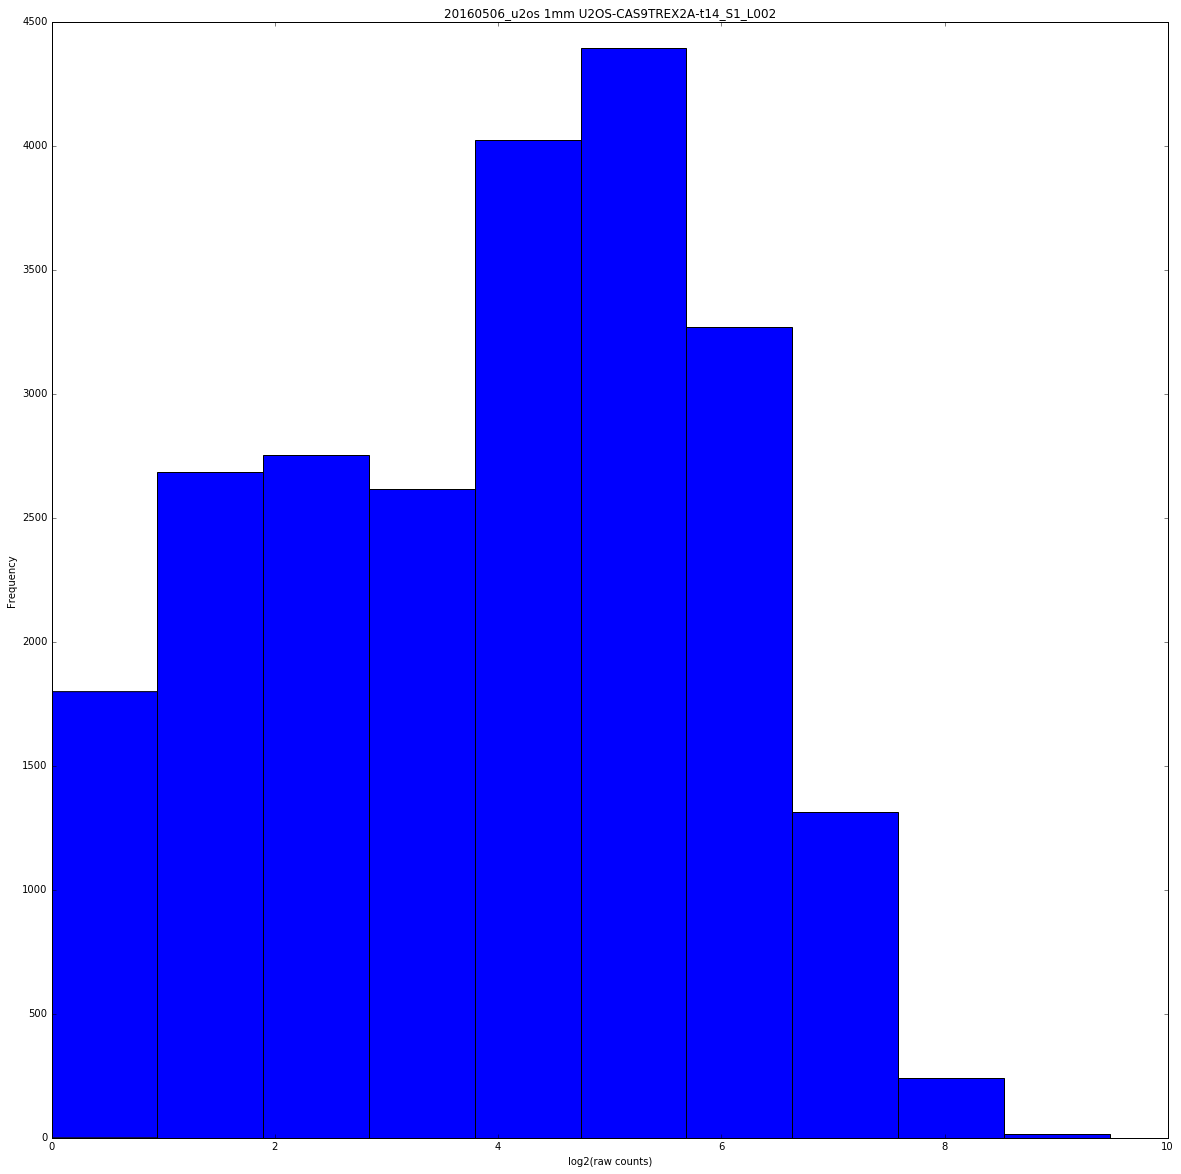

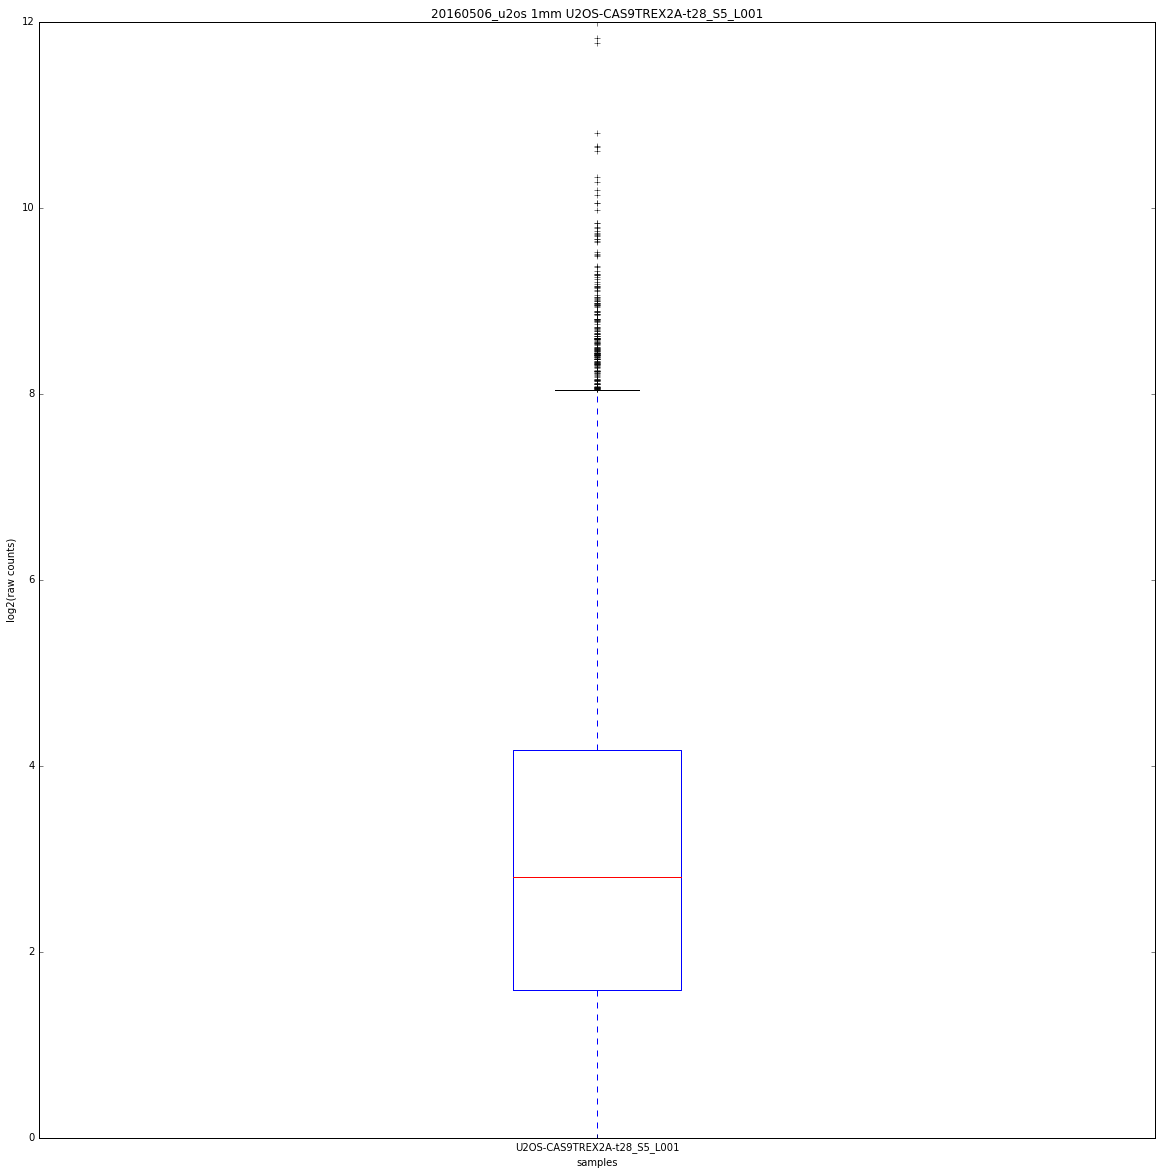

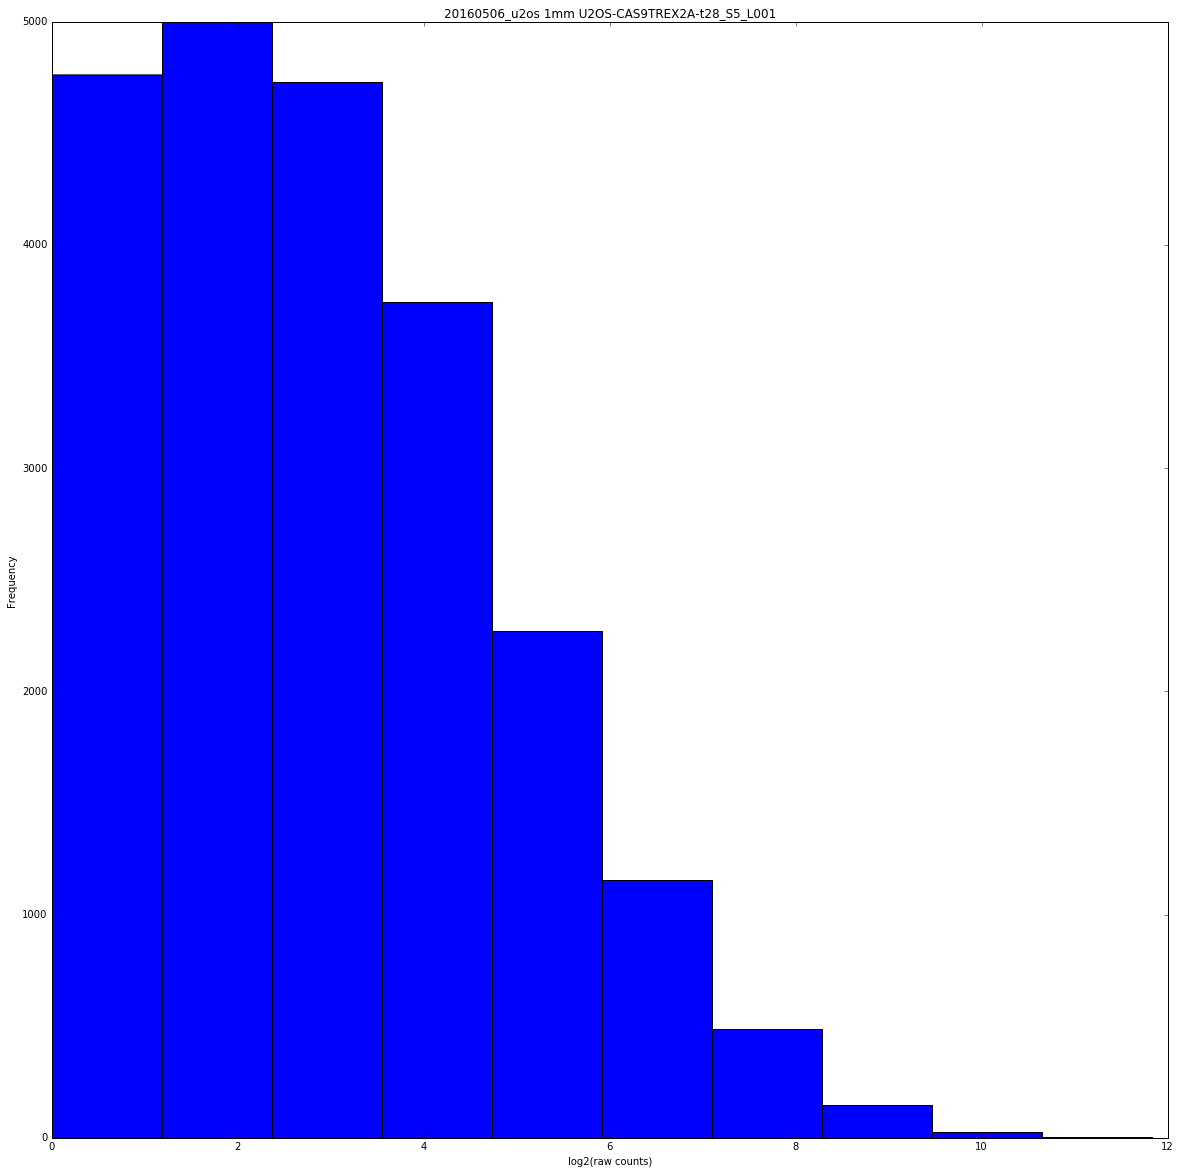

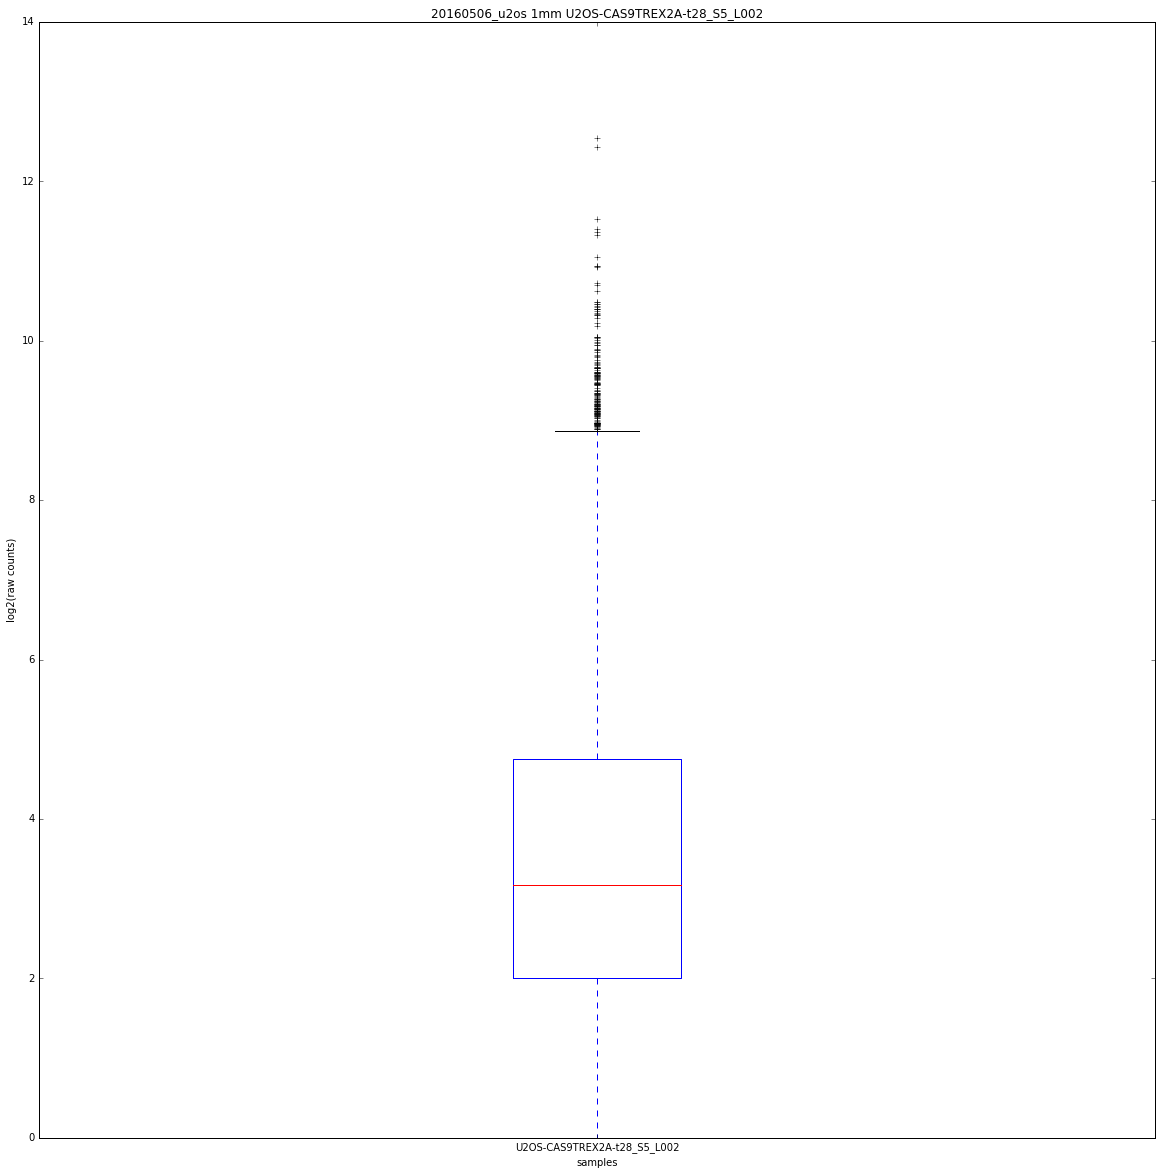

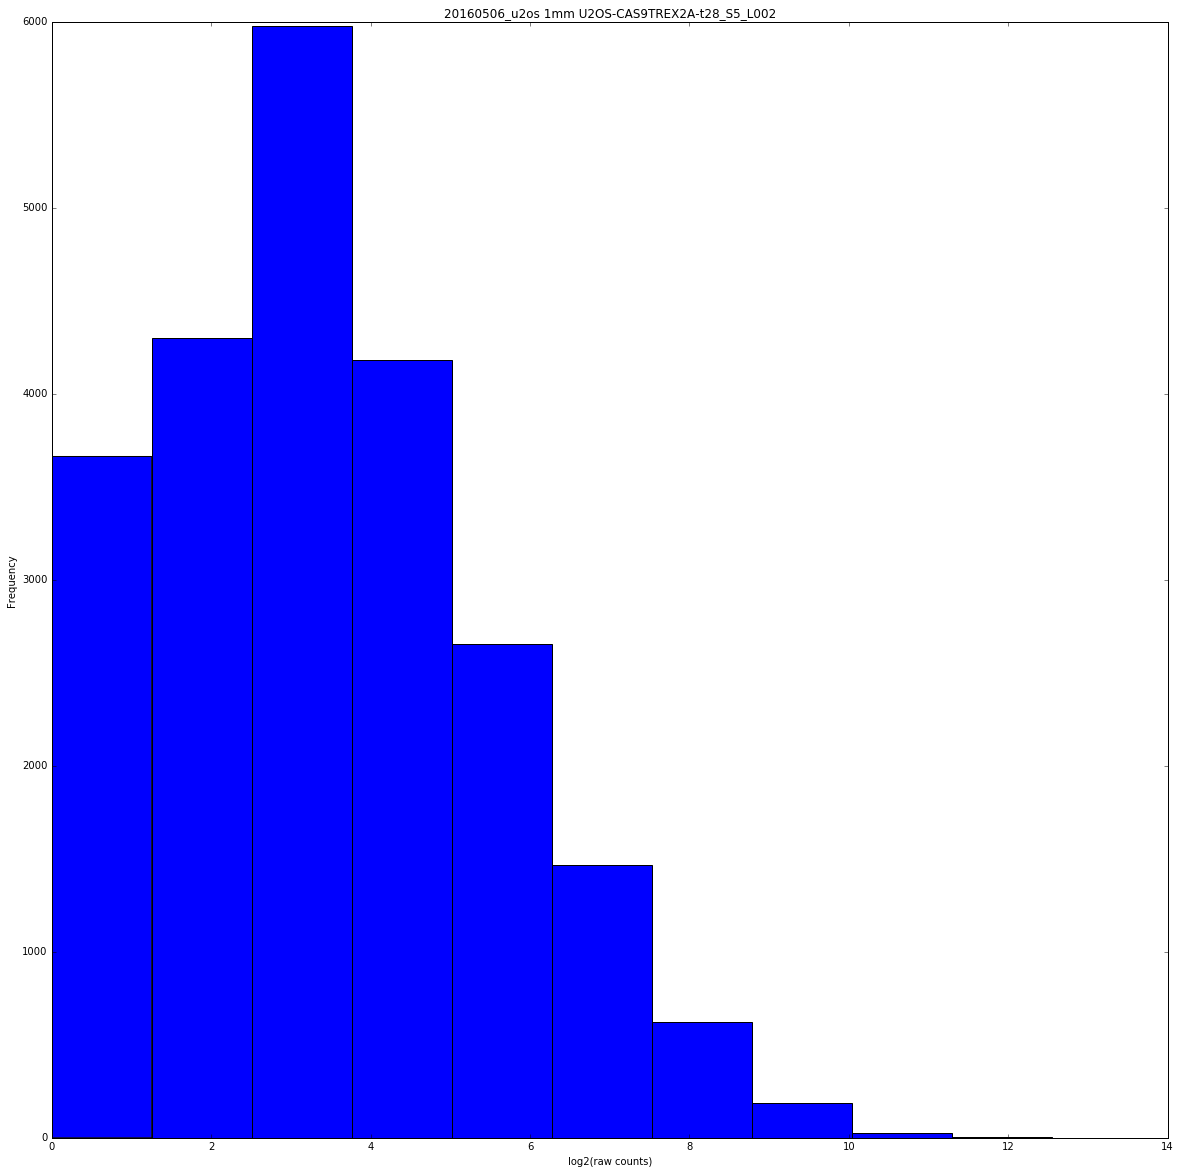

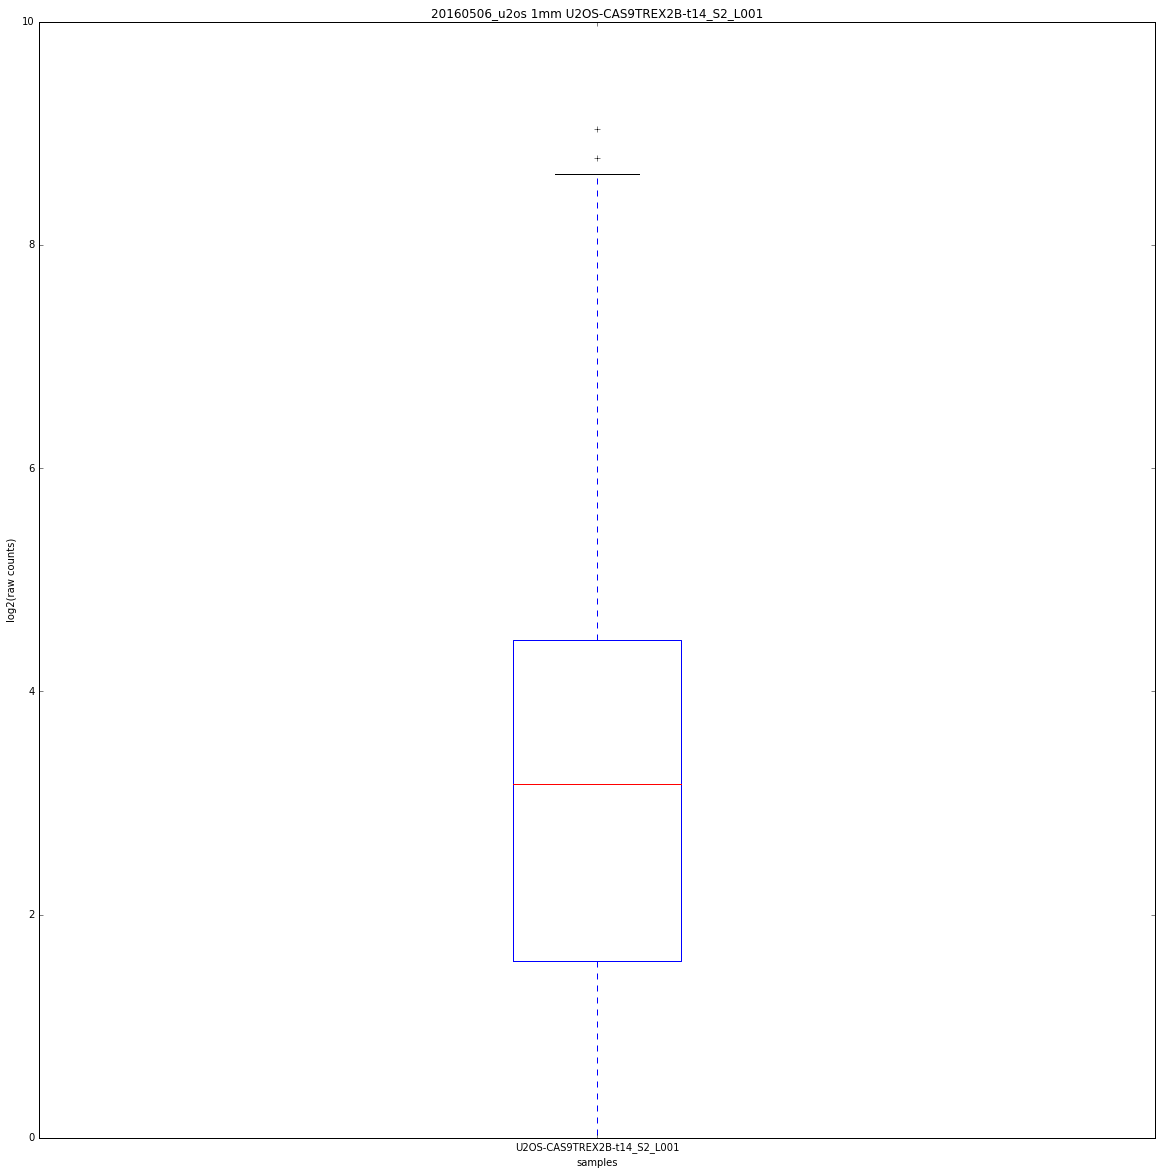

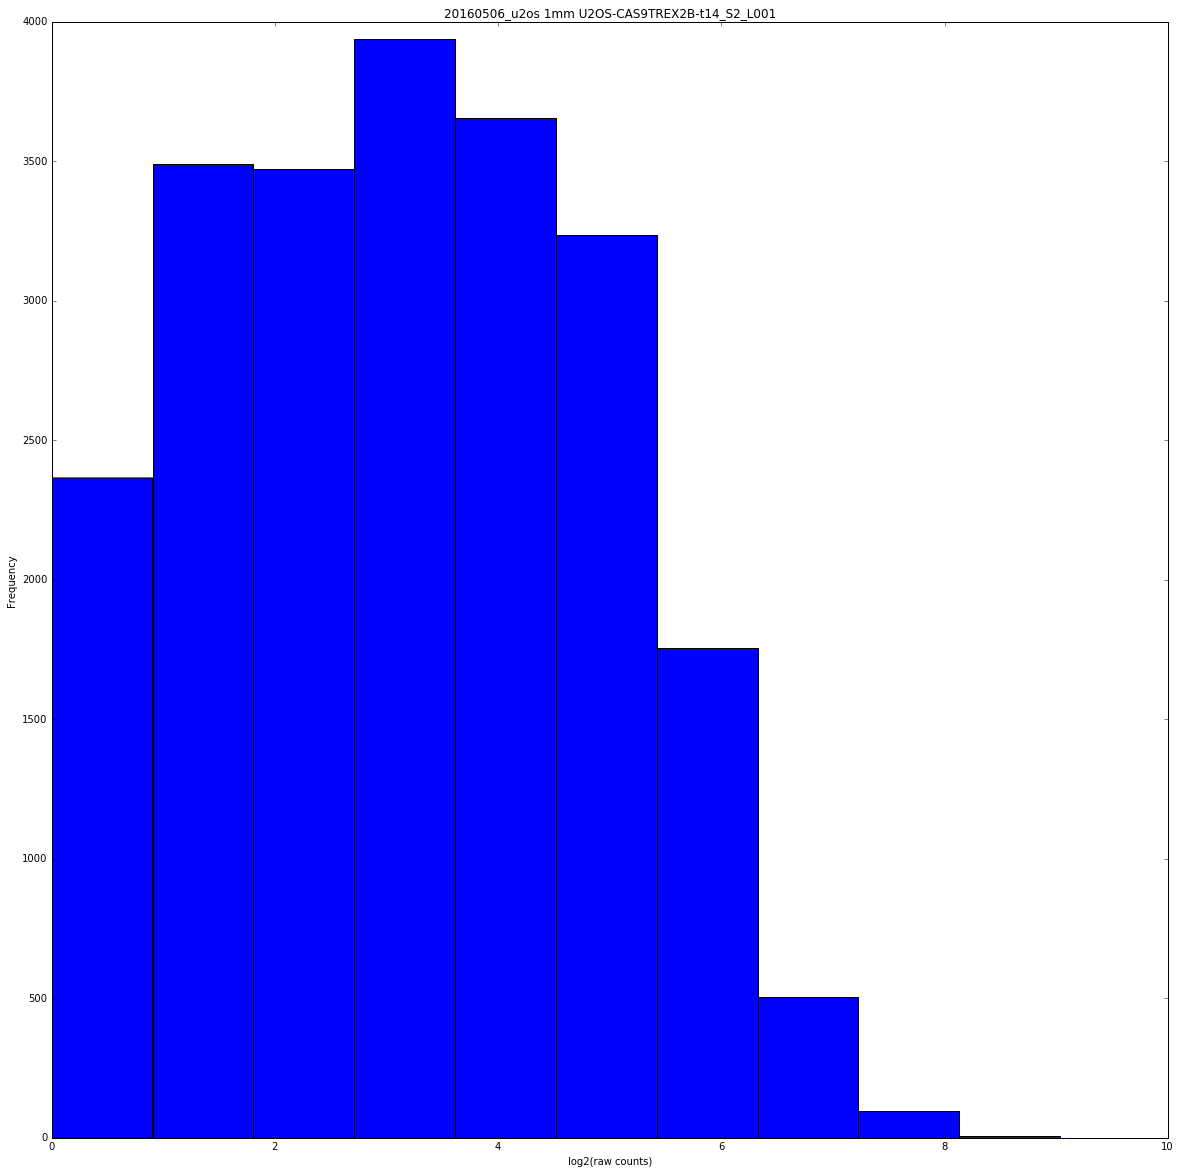

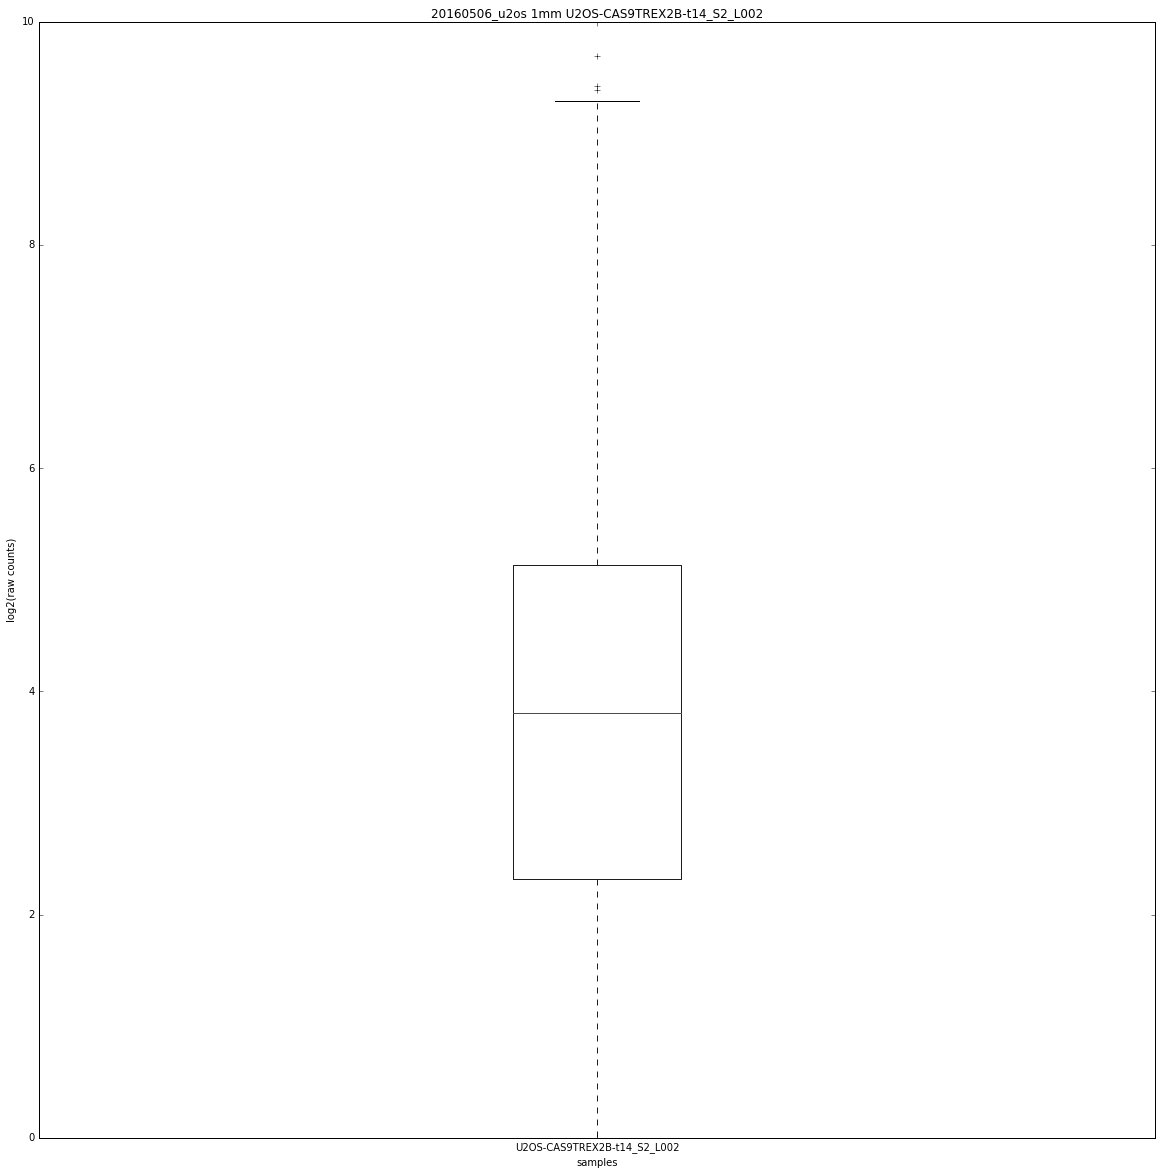

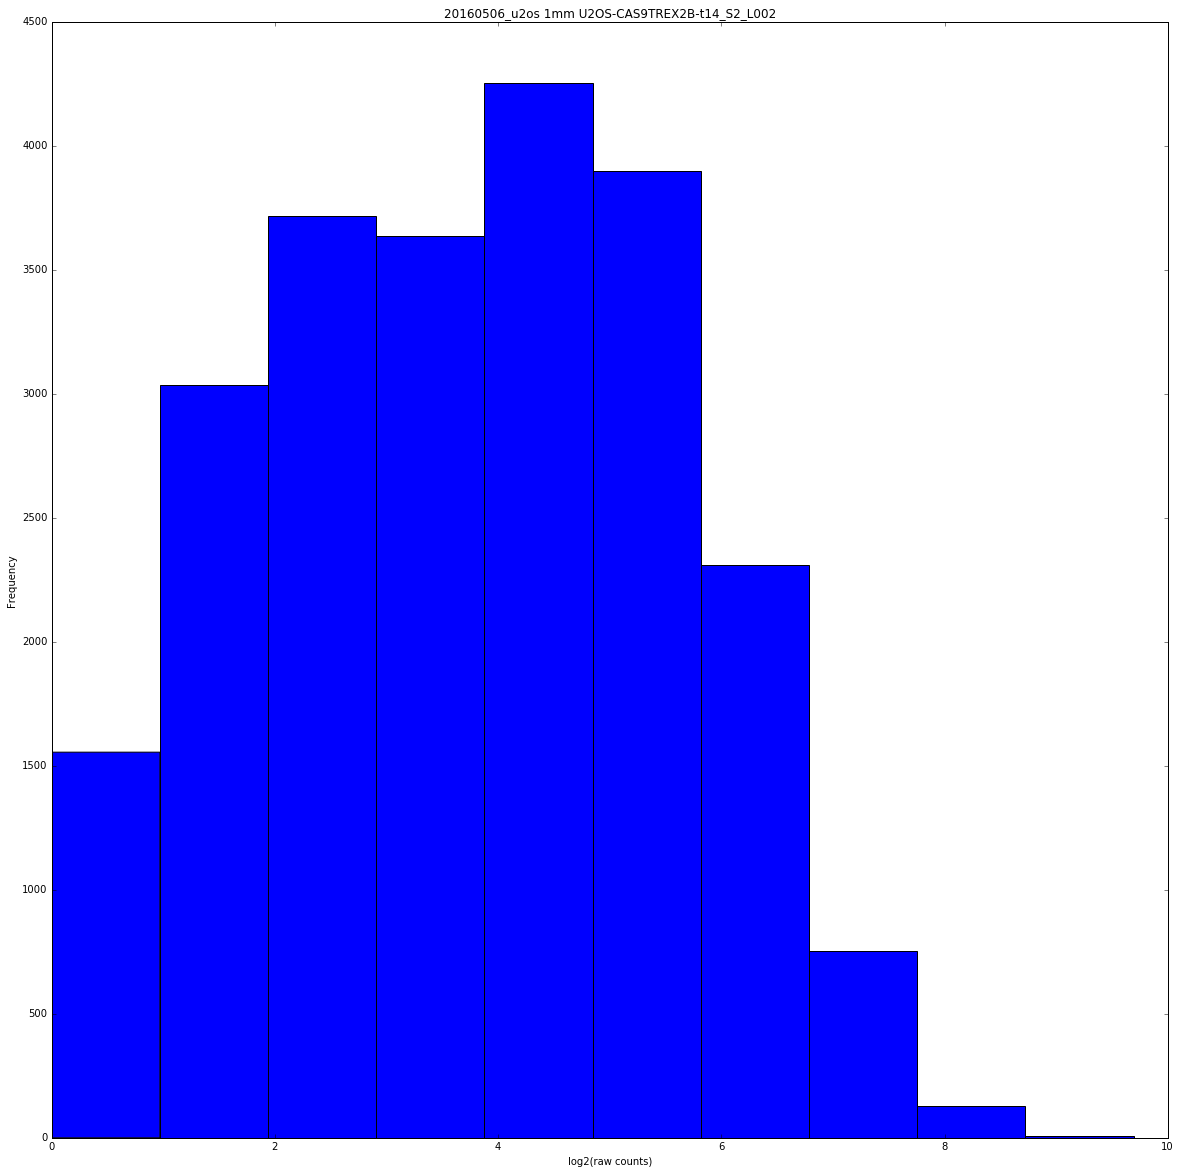

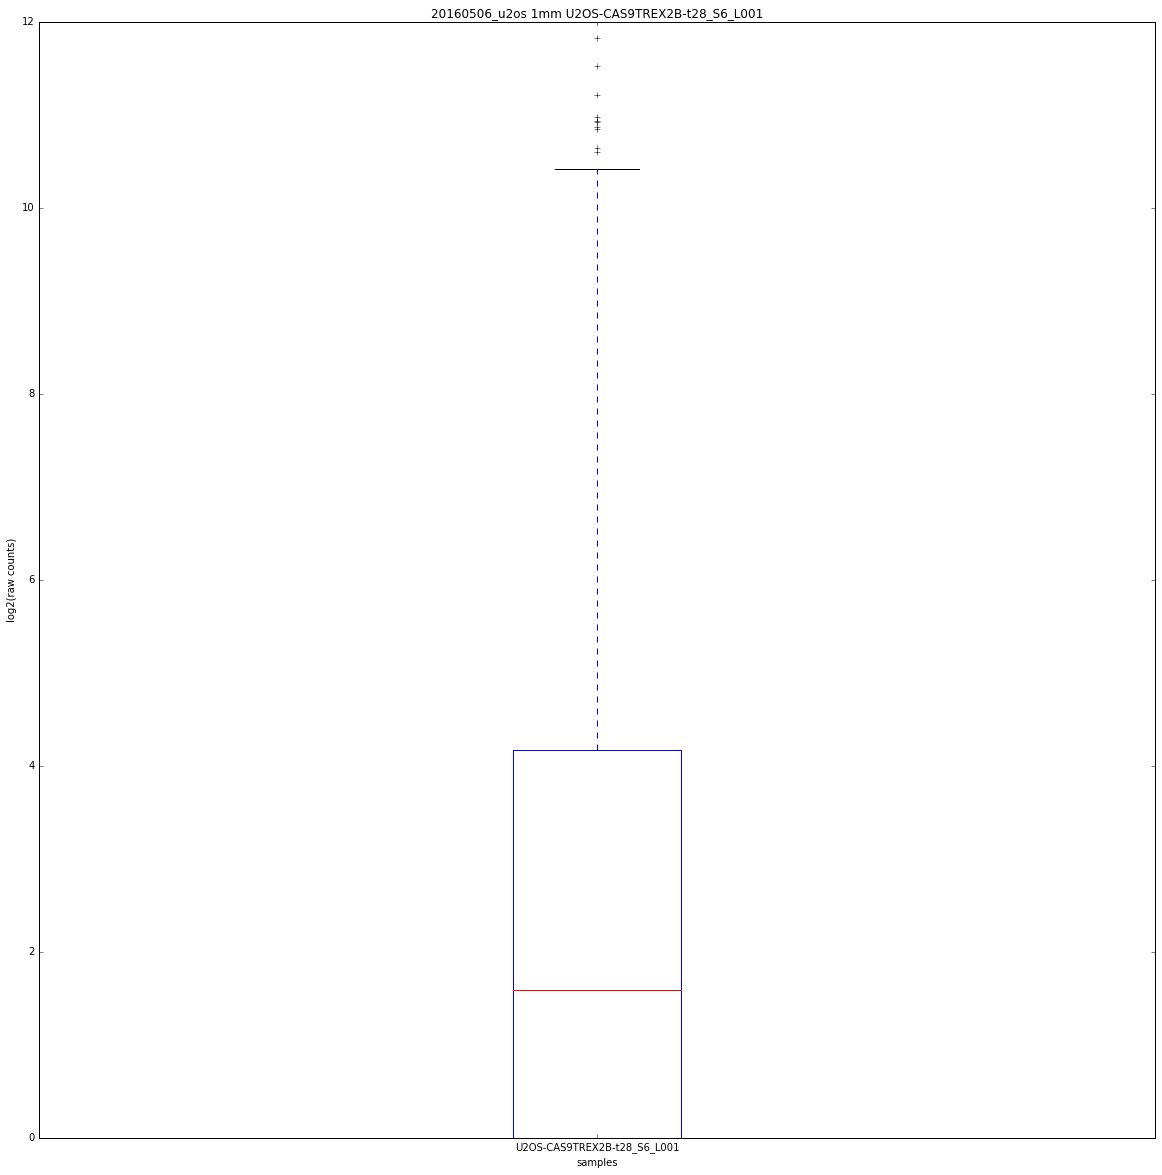

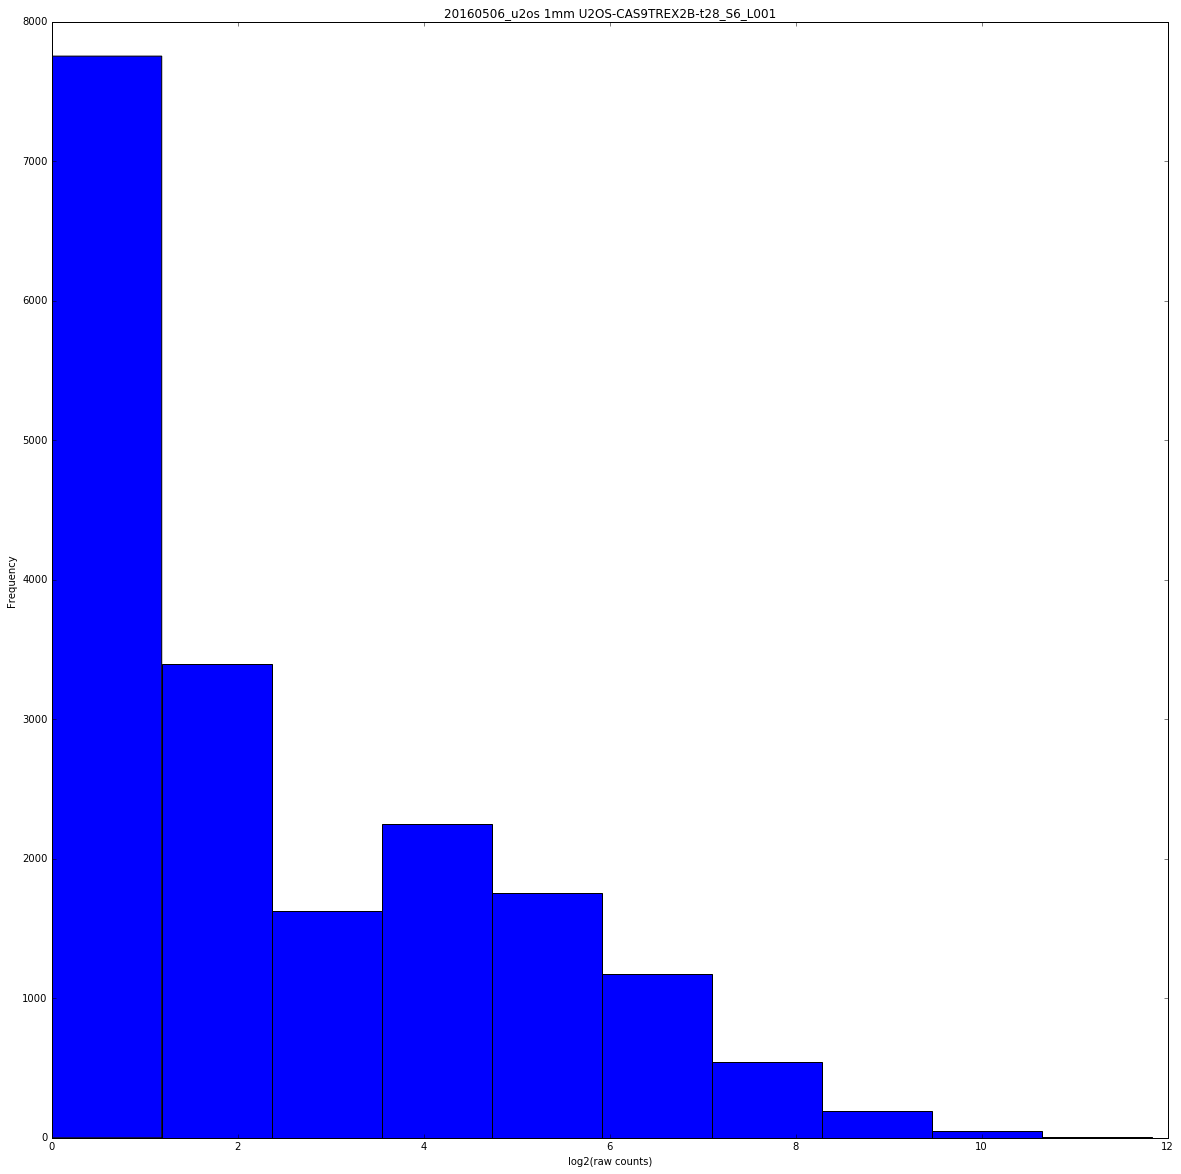

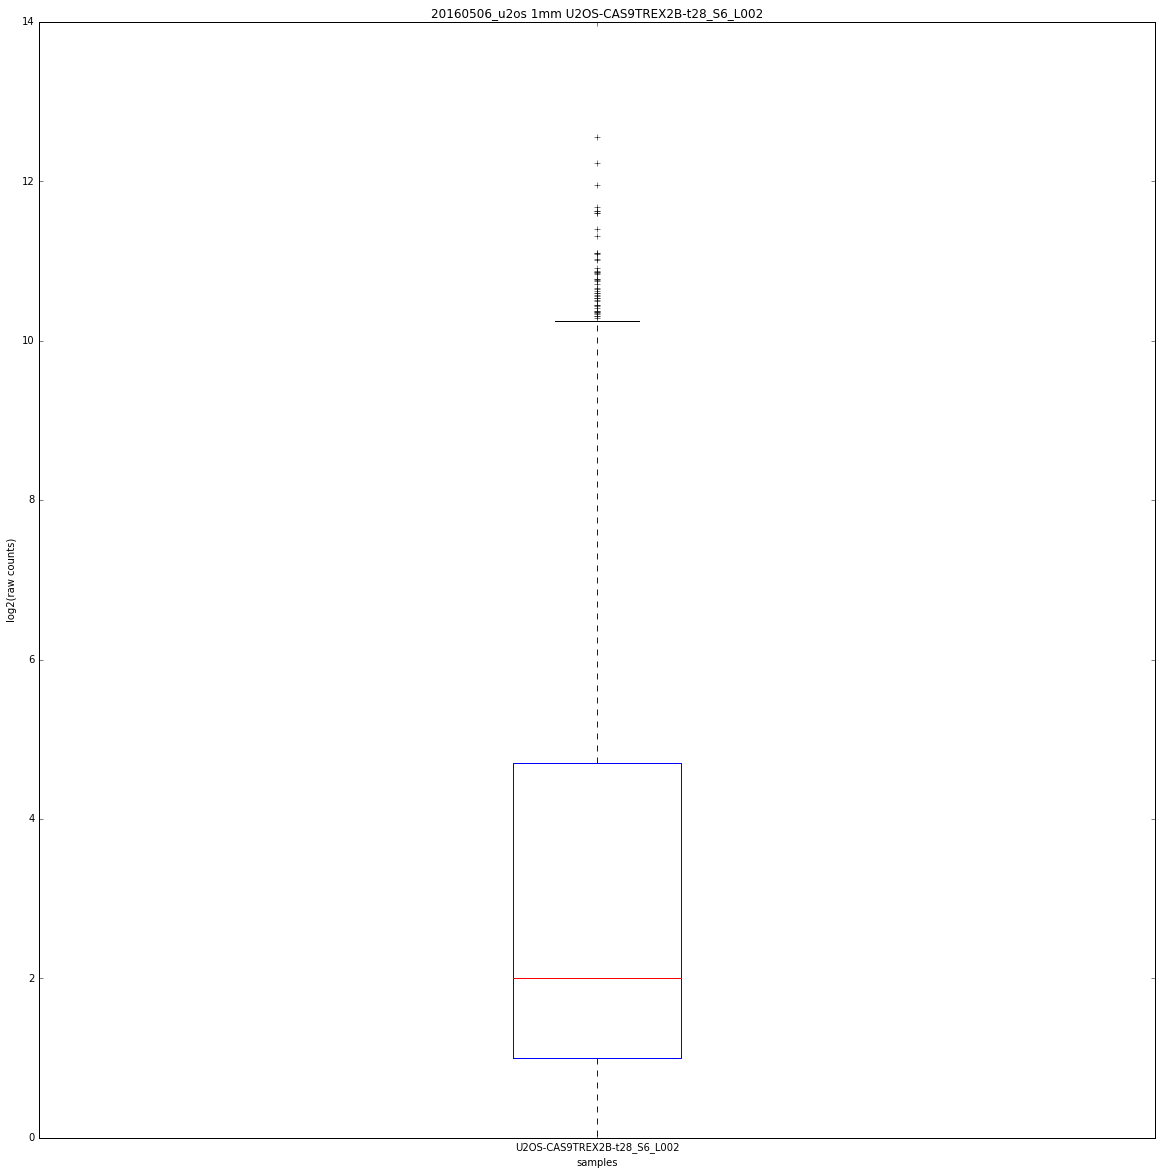

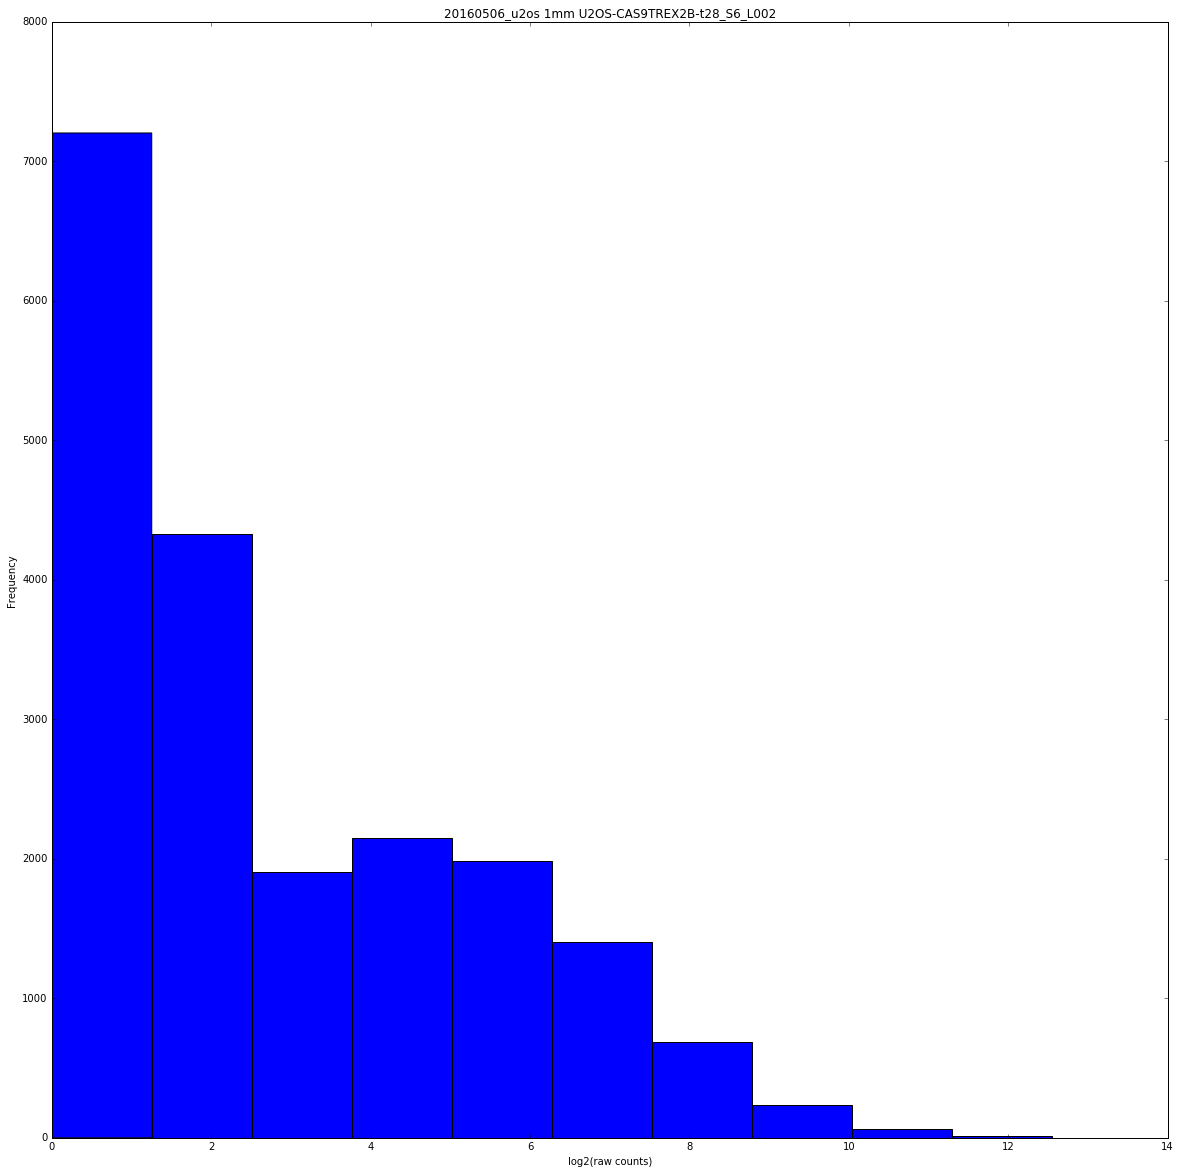

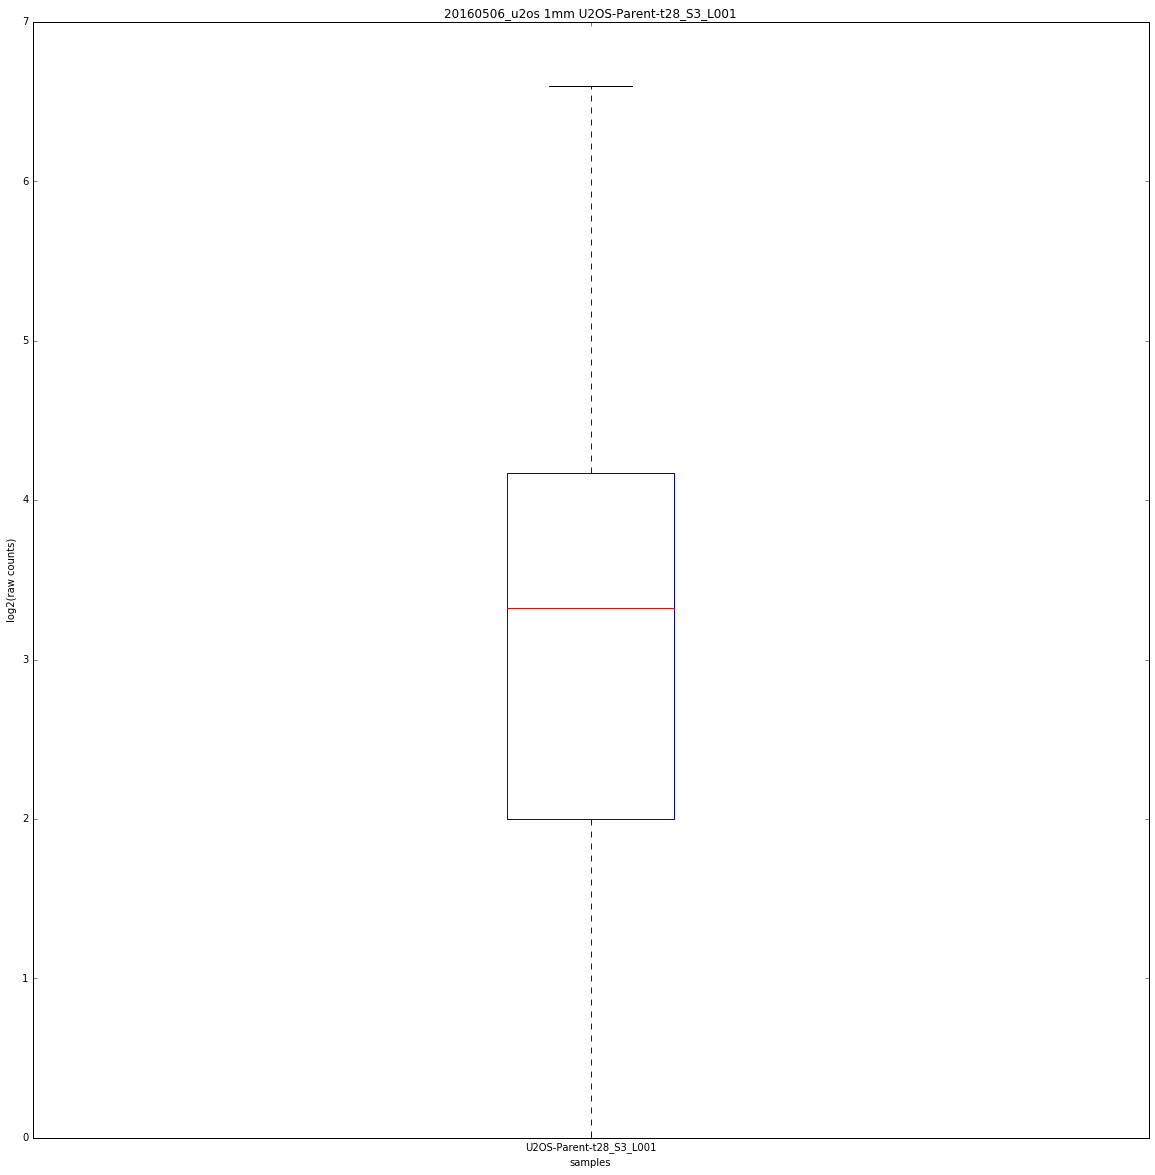

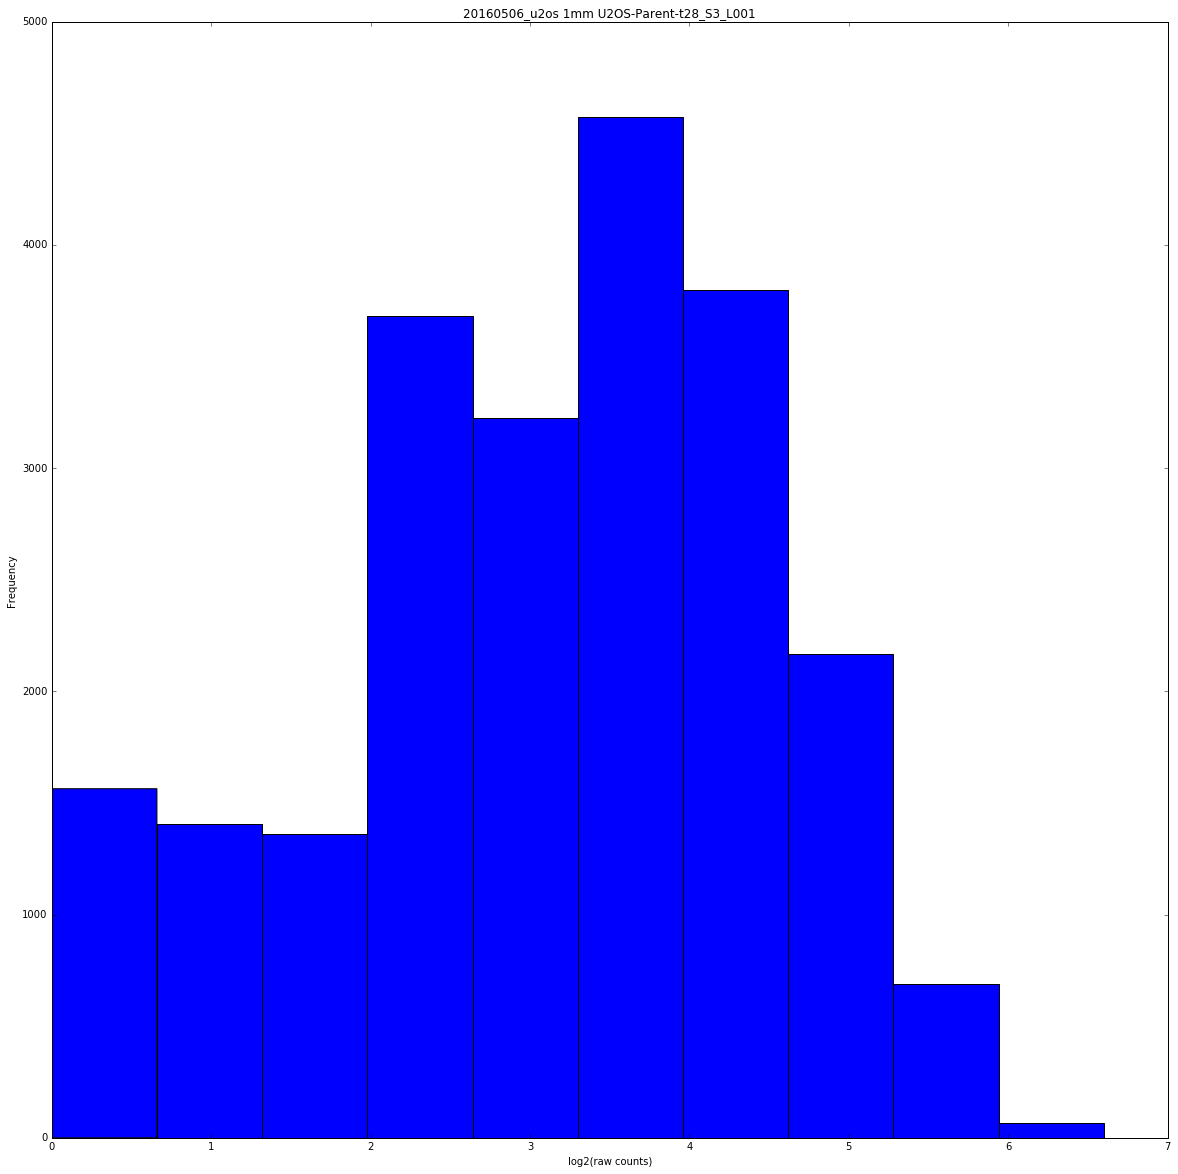

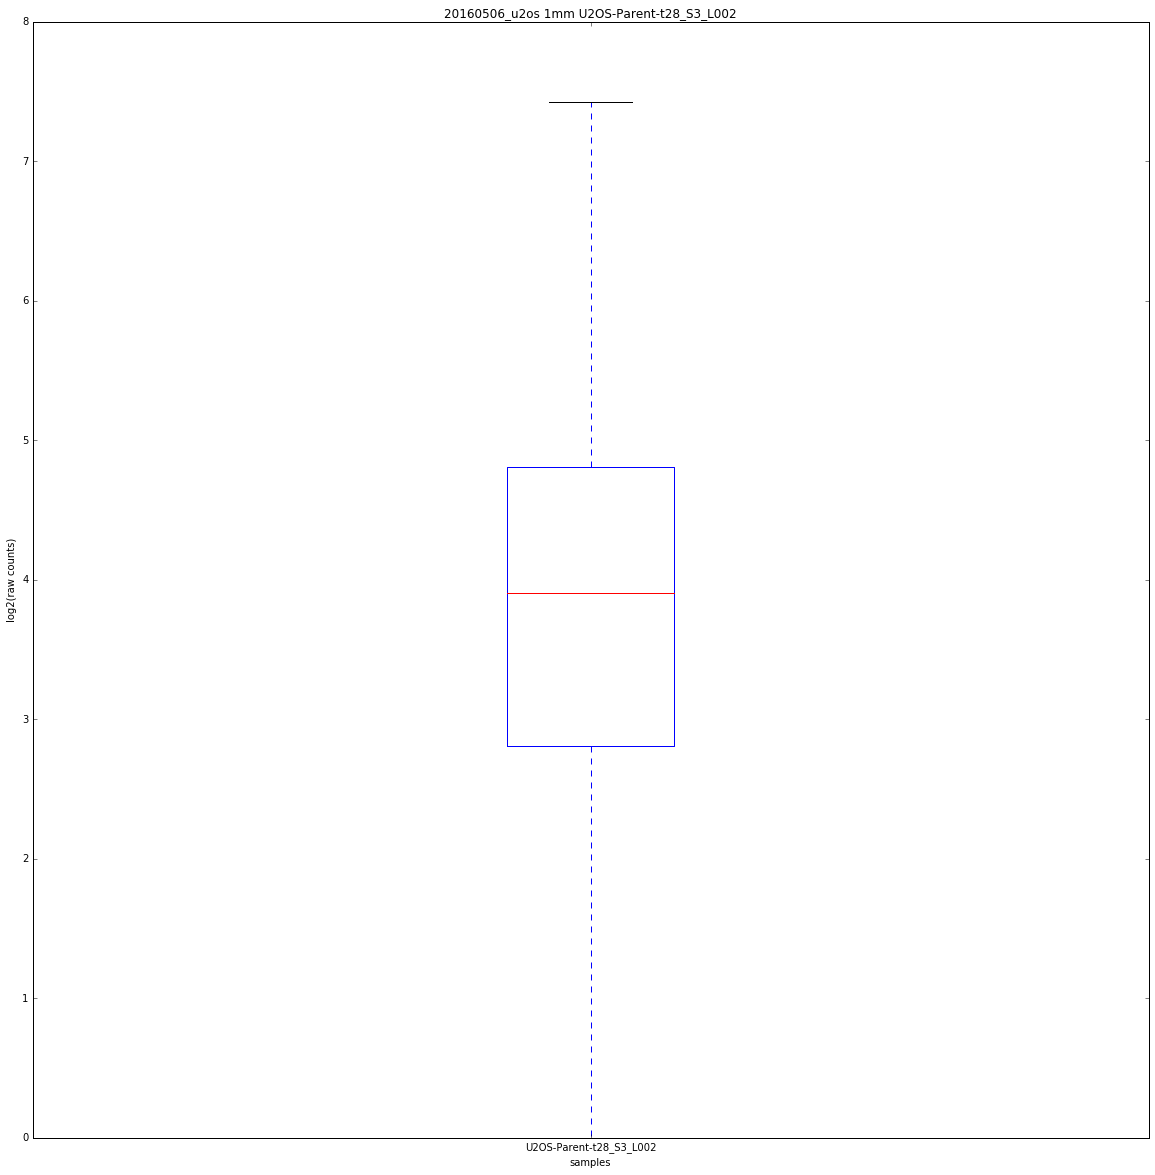

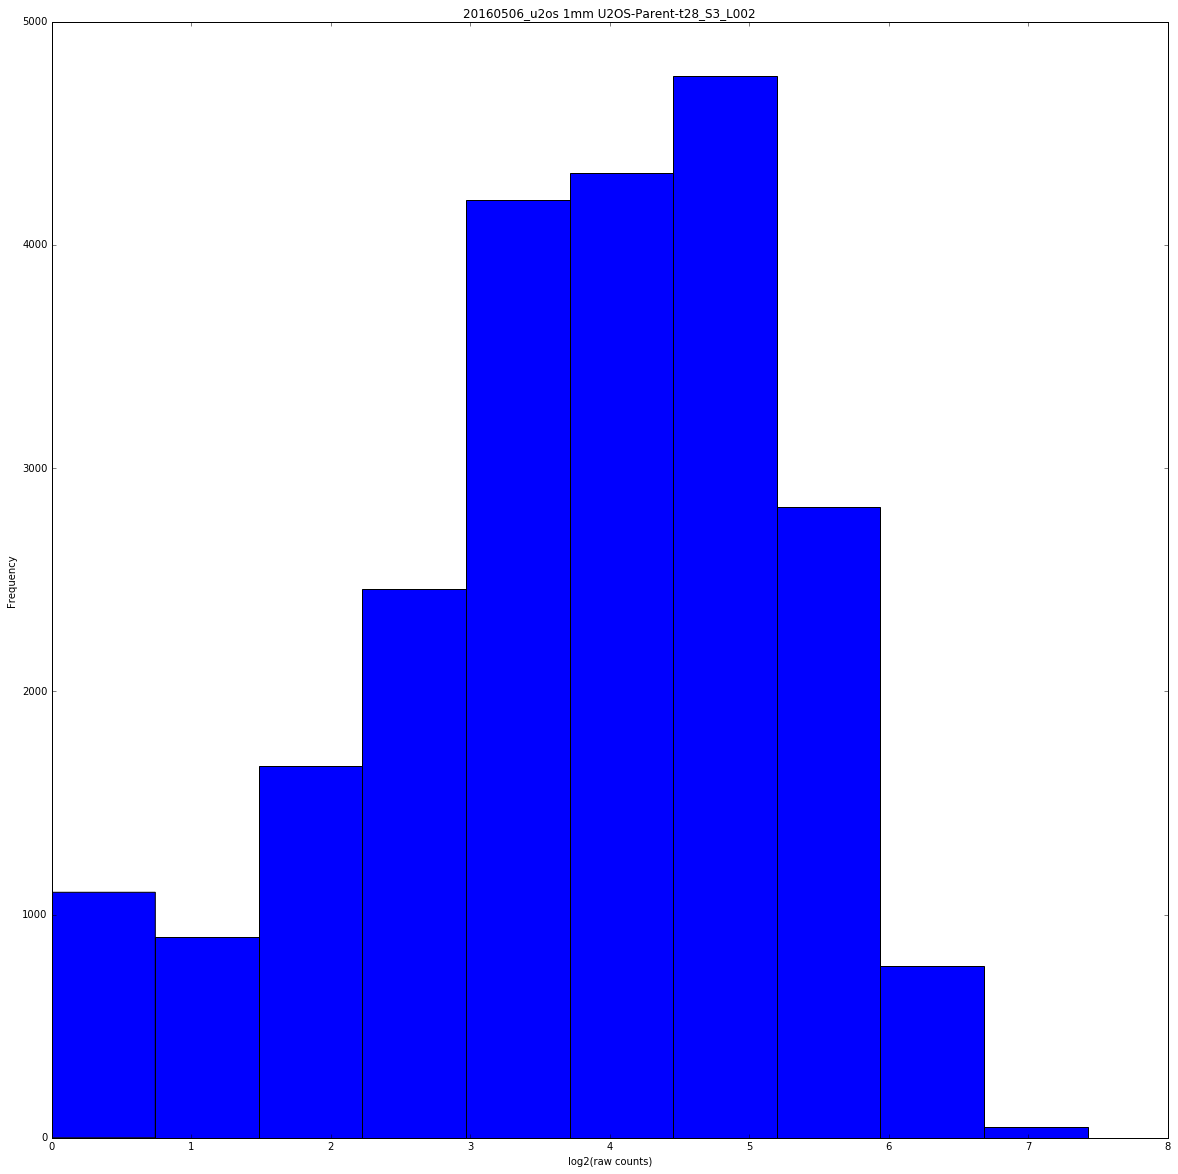

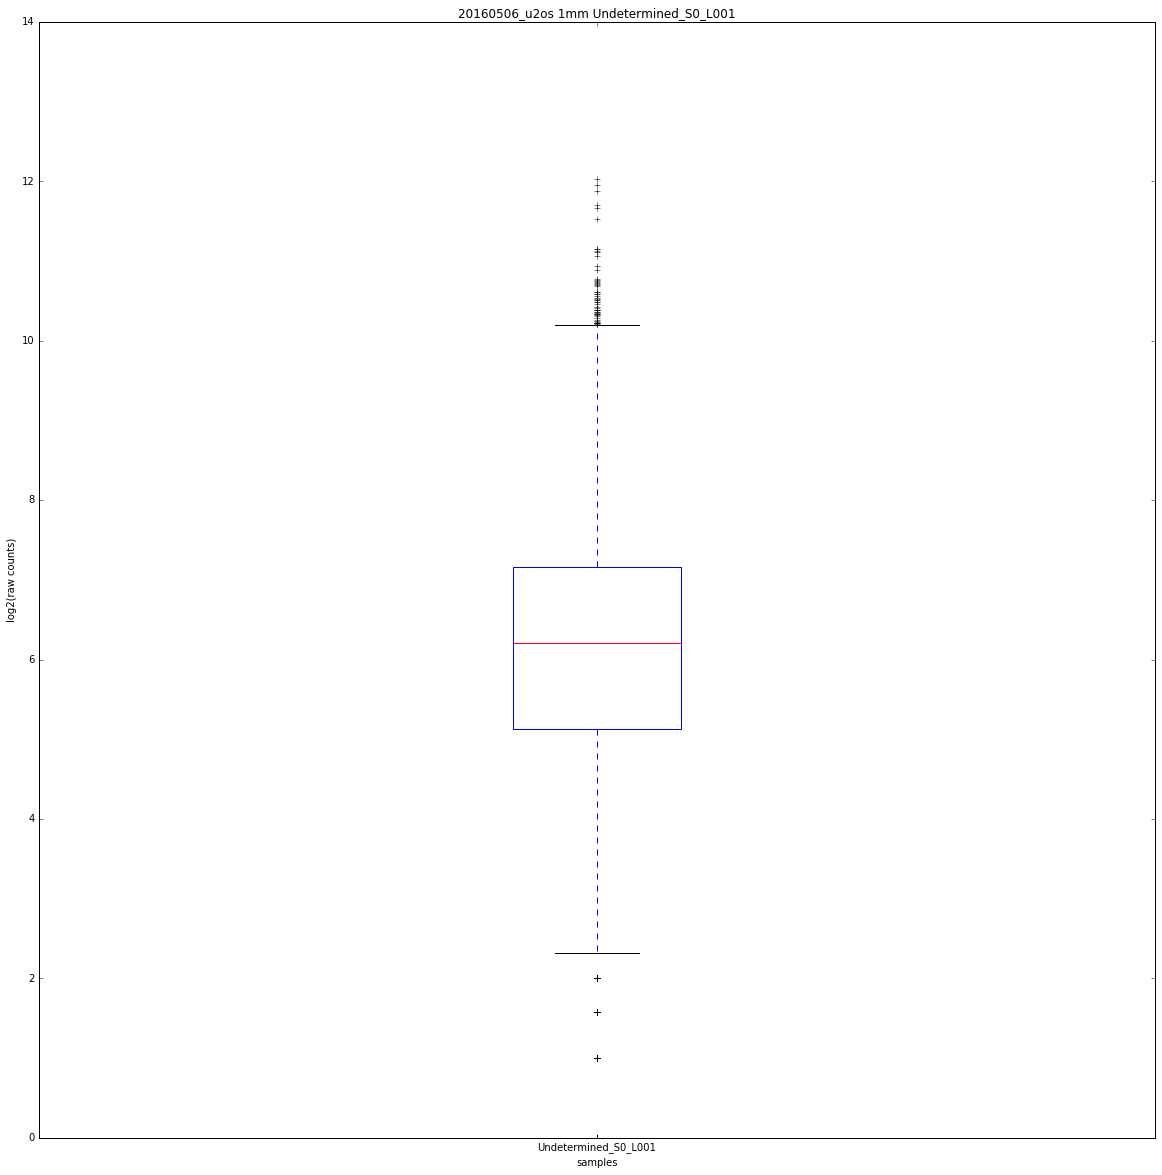

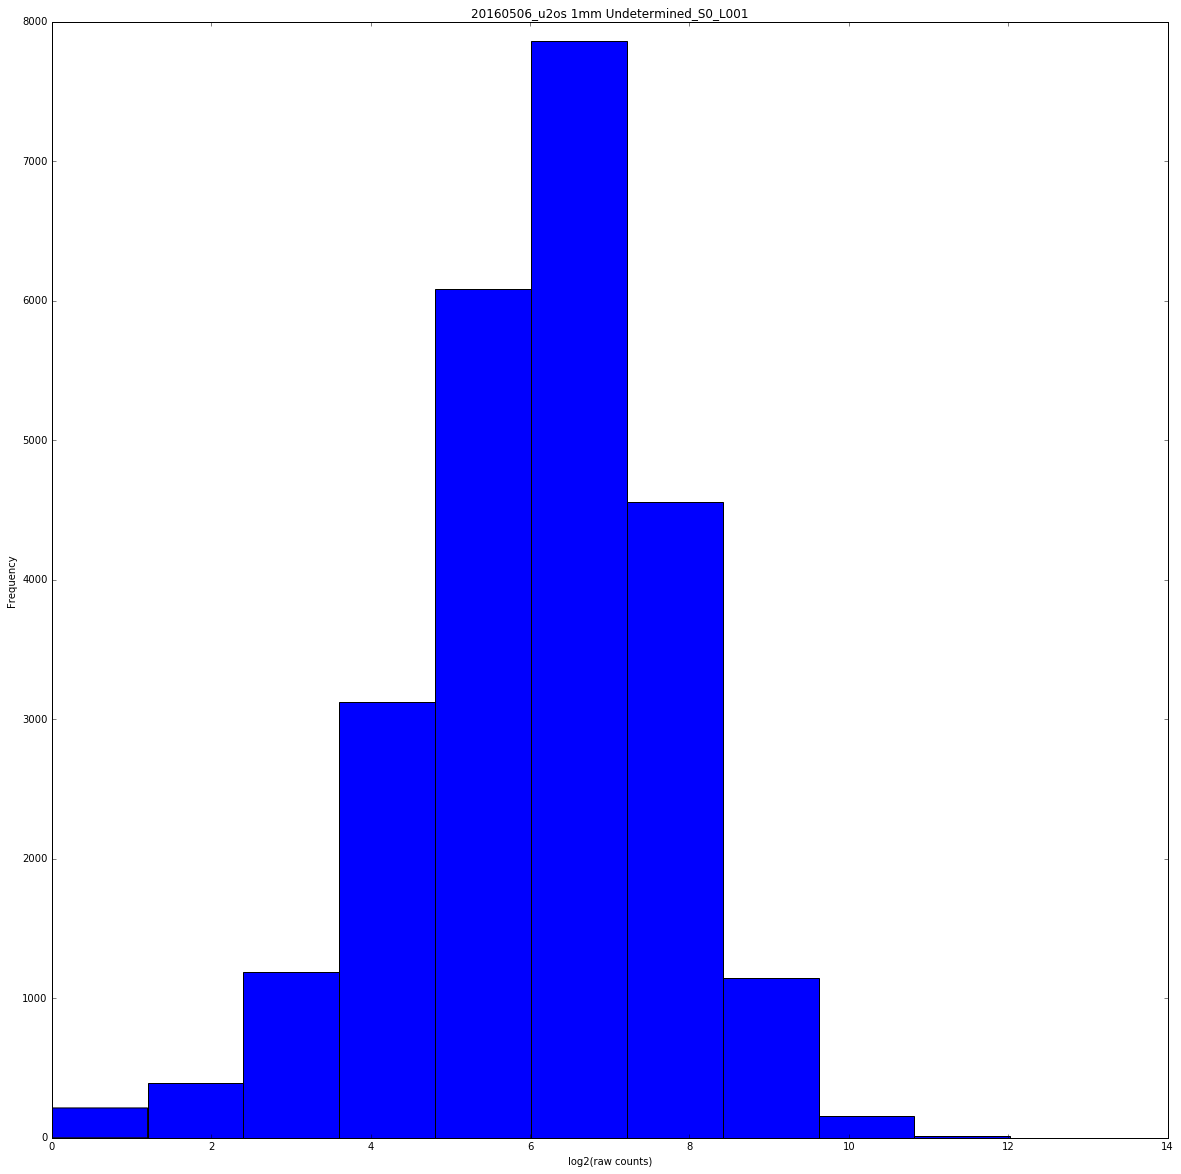

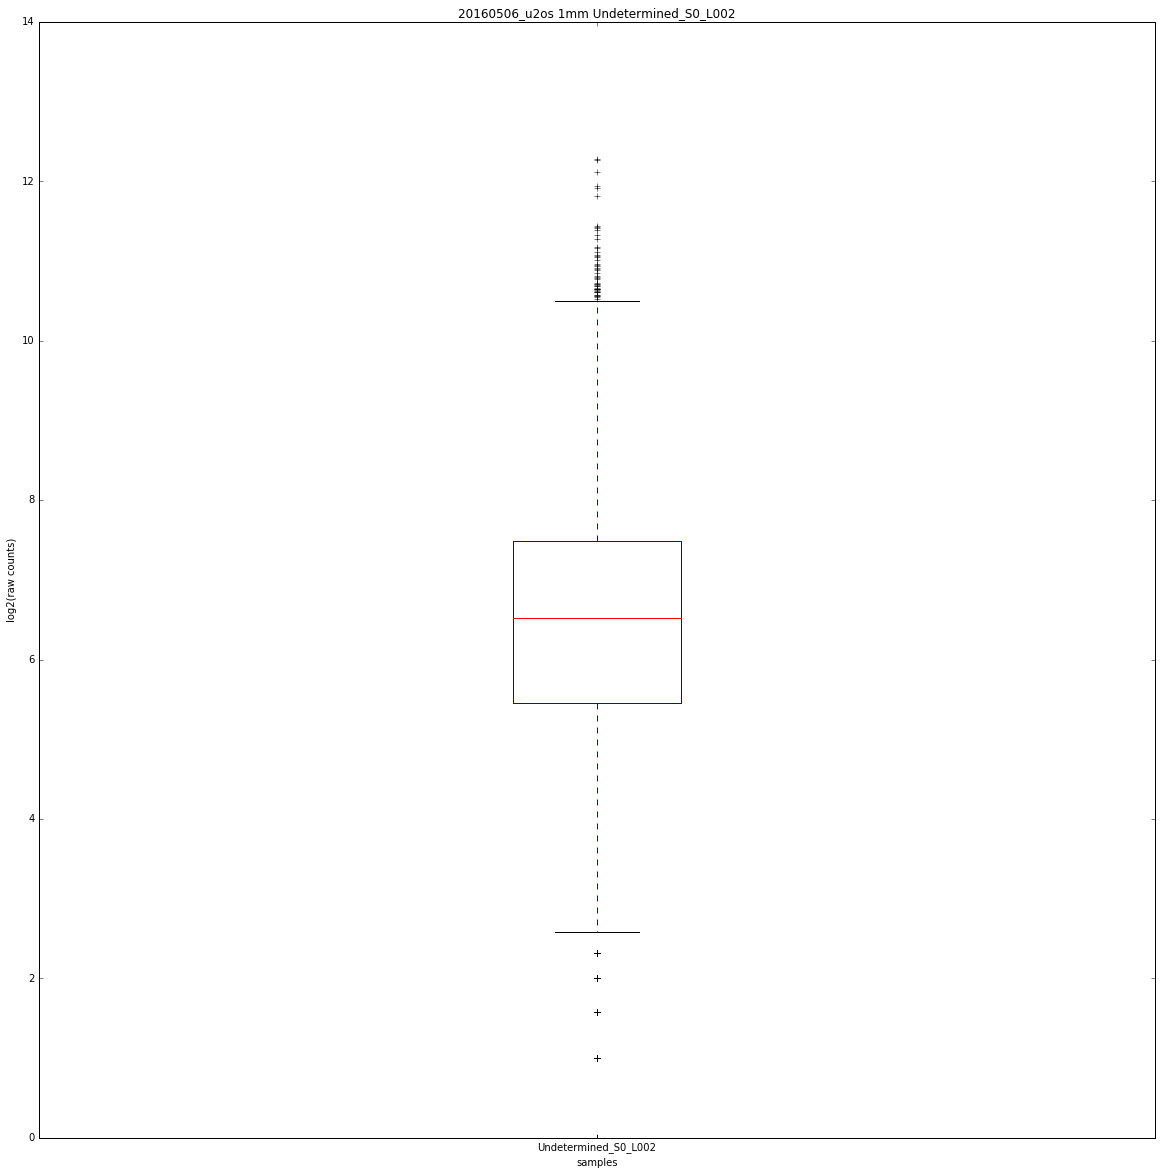

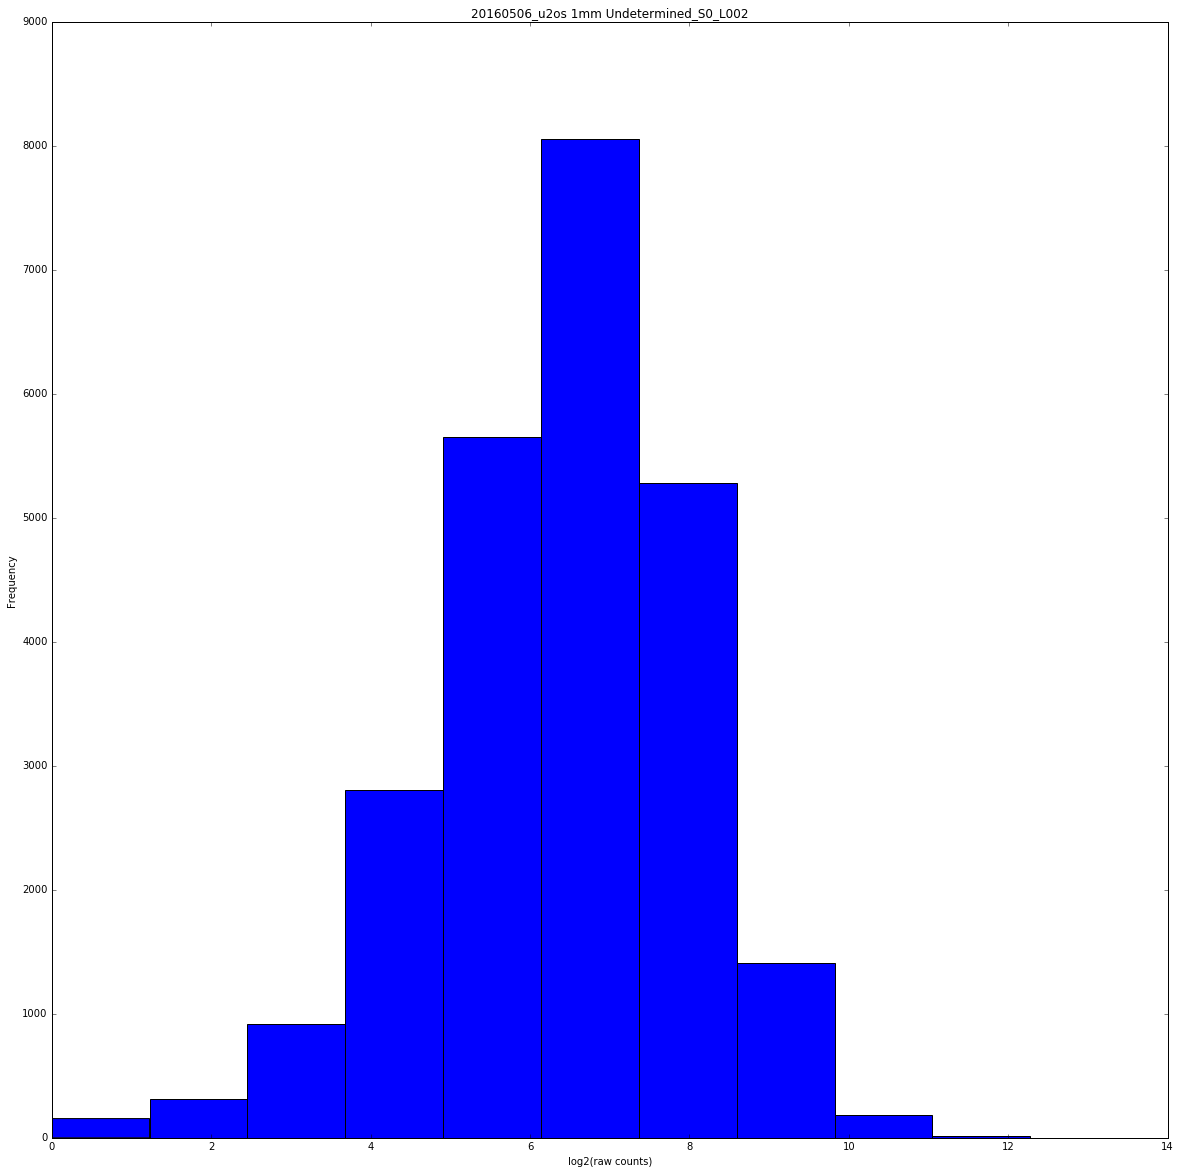

In [27]:
# this call makes one boxplot per sample        
plot_raw_counts(g_working_dir, g_dataset_name, g_alg_name, g_counts_file_suffix, g_counts_boxplot_suffix)

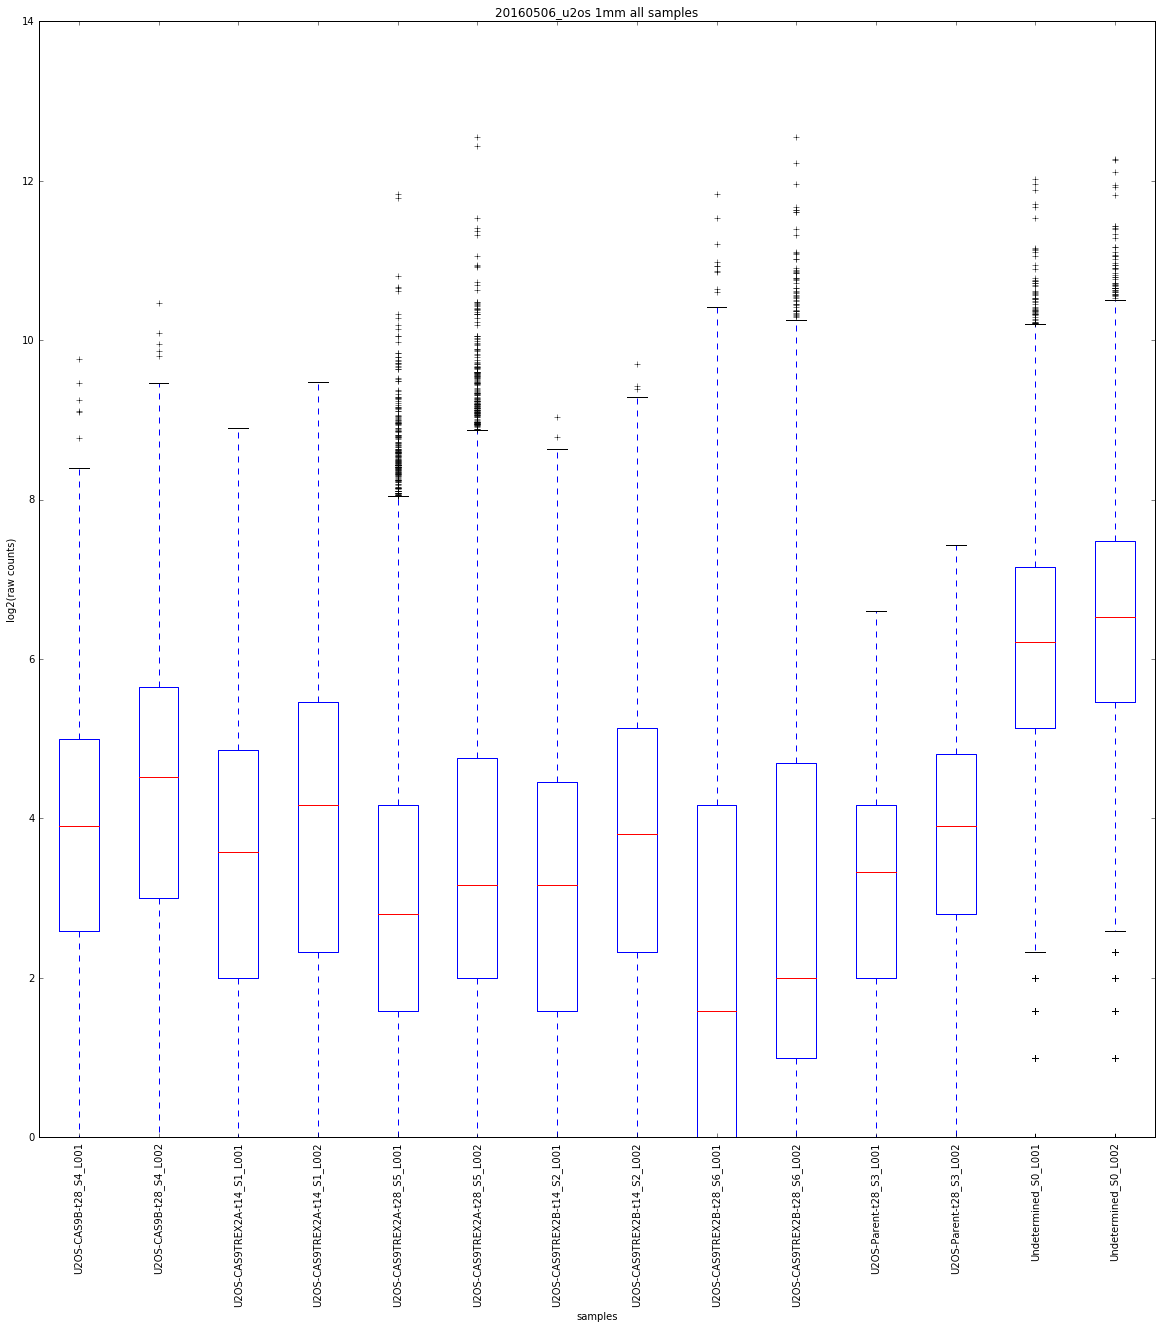

In [28]:
# this call makes one boxplot that includes ALL the samples in the combined counts file
plot_combined_raw_counts(g_working_dir, g_dataset_name, g_alg_name, g_counts_combined_file_suffix, 
                         g_counts_boxplot_suffix)